=== 원본 데이터 성능 ===
Mean Squared Error: 2.6148
R2 Score: 0.9546

=== 증강 데이터 성능 ===
Mean Squared Error: 1.9914
R2 Score: 0.9630


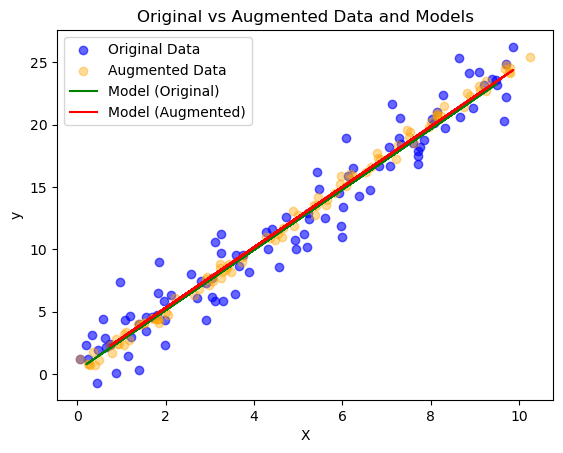

In [ ]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-1] 데이터 증강 (Data Augmentation)
# 숫자 데이터 : 노이즈와 비선형성 추가
#############################################################
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 원본 데이터 생성
np.random.seed(42)
X = np.random.rand(100, 1) * 10  # Feature
y = 2.5 * X.flatten() + np.random.randn(100) * 2  # Target with noise

# 원본 데이터프레임
original_data = pd.DataFrame({"X": X.flatten(), "y": y})

# 데이터 증강: 노이즈와 비선형성 추가
augmented_X = X + np.random.randn(100, 1) * 0.2  # 작은 노이즈 추가
augmented_y = 2.5 * augmented_X.flatten() + np.random.randn(100) * 0.5 + 0.2 * np.sin(augmented_X.flatten())  # 비선형성 추가
augmented_data = pd.DataFrame({"X": augmented_X.flatten(), "y": augmented_y})

# 데이터 병합
combined_data = pd.concat([original_data, augmented_data], ignore_index=True)

# 데이터 분리: 원본 데이터
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    original_data["X"].values.reshape(-1, 1), original_data["y"], test_size=0.2, random_state=42
)

# 데이터 분리: 증강 데이터
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
    combined_data["X"].values.reshape(-1, 1), combined_data["y"], test_size=0.2, random_state=42
)

# 모델 학습: 원본 데이터
model_orig = LinearRegression()
model_orig.fit(X_train_orig, y_train_orig)
y_pred_orig = model_orig.predict(X_test_orig)

# 모델 학습: 증강 데이터
model_aug = LinearRegression()
model_aug.fit(X_train_aug, y_train_aug)
y_pred_aug = model_aug.predict(X_test_aug)

# 성능 평가
mse_orig = mean_squared_error(y_test_orig, y_pred_orig)
r2_orig = r2_score(y_test_orig, y_pred_orig)

mse_aug = mean_squared_error(y_test_aug, y_pred_aug)
r2_aug = r2_score(y_test_aug, y_pred_aug)

# 결과 출력
print("=== 원본 데이터 성능 ===")
print(f"Mean Squared Error: {mse_orig:.4f}")
print(f"R2 Score: {r2_orig:.4f}")

print("\n=== 증강 데이터 성능 ===")
print(f"Mean Squared Error: {mse_aug:.4f}")
print(f"R2 Score: {r2_aug:.4f}")

# 시각화
plt.scatter(original_data["X"], original_data["y"], label="Original Data", color="blue", alpha=0.6)
plt.scatter(augmented_data["X"], augmented_data["y"], label="Augmented Data", color="orange", alpha=0.4)
plt.plot(X_test_orig, y_pred_orig, label="Model (Original)", color="green")
plt.plot(X_test_aug, y_pred_aug, label="Model (Augmented)", color="red")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Original vs Augmented Data and Models")
plt.legend()
plt.show()


In [ ]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-2] 교차 검증 (Cross-Validation) + 데이터증강
#############################################################
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# 데이터 로드
data = load_wine()
X, y = data.data, data.target

# 데이터를 학습 데이터와 새로운 테스트 데이터로 분리
X_train, X_new, y_train, y_new = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 증강: 노이즈 추가 및 특성 변형
np.random.seed(42)
noise = np.random.normal(0, 0.2, X_train.shape)  # 평균 0, 표준편차 0.2인 노이즈
X_augmented = X_train + noise  # 노이즈 추가
y_augmented = y_train  # 레이블은 동일

# 증강 데이터 합치기
X_combined = np.vstack((X_train, X_augmented))
y_combined = np.hstack((y_train, y_augmented))

# 기본 모델 생성
model = RandomForestClassifier(random_state=42)

# 교차 검증 없이 학습 및 새로운 데이터 평가 (기본 데이터)
model.fit(X_train, y_train)
new_predictions = model.predict(X_new)
accuracy_new_data = accuracy_score(y_new, new_predictions)

# 교차 검증 (기본 데이터)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores_without_augmentation = cross_val_score(model, X_train, y_train, cv=kf)

# 교차 검증 (증강 데이터 포함)
scores_with_augmentation = cross_val_score(model, X_combined, y_combined, cv=kf)

# 데이터 스케일링 포함한 파이프라인 구성
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 하이퍼파라미터 튜닝 (증강 데이터 포함)
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_combined, y_combined)

# 최적 모델로 교차 검증
best_model = grid_search.best_estimator_
scores_with_tuning = cross_val_score(best_model, X_combined, y_combined, cv=kf)

# 결과 출력
print("=== 새로운 데이터로 평가 (기본 데이터) ===")
print(f"새로운 데이터 정확도: {accuracy_new_data:.4f}")

print("\n=== 기본 데이터 교차 검증 결과 ===")
print(f"교차 검증 점수 (기본 데이터): {scores_without_augmentation}")
print(f"평균 교차 검증 점수: {scores_without_augmentation.mean():.4f}")

print("\n=== 증강 데이터 포함 교차 검증 결과 ===")
print(f"교차 검증 점수 (증강 데이터 포함): {scores_with_augmentation}")
print(f"평균 교차 검증 점수: {scores_with_augmentation.mean():.4f}")

print("\n=== 하이퍼파라미터 튜닝 결과 (증강 데이터 포함) ===")
print(f"최적 파라미터: {grid_search.best_params_}")
print(f"최적 교차 검증 점수: {grid_search.best_score_:.4f}")

print("\n=== 최적 모델 교차 검증 점수 (증강 데이터 포함) ===")
print(f"교차 검증 점수: {scores_with_tuning}")
print(f"평균 교차 검증 점수: {scores_with_tuning.mean():.4f}")


=== 새로운 데이터로 평가 (기본 데이터) ===
새로운 데이터 정확도: 1.0000

=== 기본 데이터 교차 검증 결과 ===
교차 검증 점수 (기본 데이터): [0.93103448 0.96551724 1.         1.         1.        ]
평균 교차 검증 점수: 0.9793

=== 증강 데이터 포함 교차 검증 결과 ===
교차 검증 점수 (증강 데이터 포함): [0.96491228 1.         0.96491228 0.98245614 0.98214286]
평균 교차 검증 점수: 0.9789

=== 하이퍼파라미터 튜닝 결과 (증강 데이터 포함) ===
최적 파라미터: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
최적 교차 검증 점수: 0.9895

=== 최적 모델 교차 검증 점수 (증강 데이터 포함) ===
교차 검증 점수: [0.96491228 1.         0.96491228 0.98245614 0.98214286]
평균 교차 검증 점수: 0.9789


In [ ]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-3] 데이터 스케일링 (Data Scaling)
# MinMaxScaler : 데이터를 특정 범위(기본값: [0, 1])로 정규화
# 𝑋 : 원본 데이터 값
# 𝑋_{min}  : 각 열의 최소값
# 𝑋_{max}  : 각 열의 최대값
# 𝑋′ : 변환된 데이터 값
# 𝑋′ = (𝑋 - 𝑋_{min}) / (𝑋_{max} - 𝑋_{min})
#############################################################
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# 데이터 출력 형식 설정 (소수점 이하 4자리까지)
np.set_printoptions(precision=4, suppress=True)

# 데이터 생성
X, y = make_classification(
    n_samples=500,
    n_features=5,
    n_informative=3,
    n_redundant=0,
    random_state=42
)

# 인위적으로 특성의 스케일 차이를 크게 만듦
X[:, 0] *= 1    # 첫 번째 특성: 0~1
X[:, 1] *= 100  # 두 번째 특성: 0~100
X[:, 2] *= 1000 # 세 번째 특성: 0~1000

print("원본 데이터 (일부):\n", X[:5])

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# KNN 모델 생성
knn = KNeighborsClassifier()

# 1. 원본 데이터로 평가
knn.fit(X_train, y_train)
y_pred_original = knn.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred_original)

# 2. 데이터 스케일링
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n스케일링된 데이터 (훈련 세트 일부):\n", X_train_scaled[:5])

# 스케일링된 데이터 학습 및 평가
knn.fit(X_train_scaled, y_train)
y_pred_scaled = knn.predict(X_test_scaled)
accuracy_scaled = accuracy_score(y_test, y_pred_scaled)

# 결과 출력
print("\n=== 평가 결과 ===")
print(f"원본 데이터 테스트 정확도: {accuracy_original:.4f}")
print(f"스케일링된 데이터 테스트 정확도: {accuracy_scaled:.4f}")



원본 데이터 (일부):
 [[  -1.8306   -9.534  -654.0757    0.7241   -0.1813]
 [   0.2603    8.0151 -413.4652   -1.2733    1.4826]
 [  -1.3796    9.8744 -971.6567   -0.0728   -1.5796]
 [  -0.9981  -16.1506 1051.9476    2.3985    2.1207]
 [  -0.3696  122.3565  621.5719    0.0128   -1.4224]]

스케일링된 데이터 (훈련 세트 일부):
 [[0.5246 0.7534 0.5159 0.7898 0.714 ]
 [0.6738 0.2881 0.6199 0.4736 0.4592]
 [0.3458 0.3688 0.2804 0.1617 0.5876]
 [0.3992 0.5641 0.541  0.6432 0.4749]
 [0.5227 0.4134 0.4271 0.1323 0.6014]]

=== 평가 결과 ===
원본 데이터 테스트 정확도: 0.8480
스케일링된 데이터 테스트 정확도: 0.9360


In [ ]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-4] 데이터 불균형 처리 (Handling Imbalanced Data)
# ADASYN + SMOTE(Synthetic Minority Over-sampling Technique)
#############################################################
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import pandas as pd

# 극단적인 불균형 데이터 생성
X, y = make_classification(
    n_classes=2,          # 이진 분류
    class_sep=2,          # 클래스 간 분리 정도
    weights=[0.005, 0.995], # 클래스 비율: 0.5% vs 99.5%
    n_informative=3,      # 정보가 있는 독립 변수 3개
    n_redundant=1,        # 중복된 독립 변수 1개
    flip_y=0,             # 라벨 뒤집기 비율 없음
    n_features=5,         # 총 특성 수: 5개
    n_clusters_per_class=1, # 각 클래스 하나의 클러스터
    n_samples=2000,       # 총 샘플 수: 2000개
    random_state=10       # 난수 고정
)
print("원본 클래스 분포:\n", pd.Series(y).value_counts())

# 교차 검증 설정
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 1. 원본 데이터 교차 검증 평가
model = RandomForestClassifier(random_state=42)
scores_original = cross_val_score(model, X, y, cv=kf, scoring='roc_auc')
print("\n[교차 검증] 원본 데이터 ROC-AUC:", scores_original.mean())

# 데이터 분리 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 2. 원본 데이터 분리 평가
model.fit(X_train, y_train)
y_pred_original = model.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred_original)

print("\n[분리 평가] === 원본 데이터 평가 결과 ===")
print(f"정확도: {accuracy_original:.4f}")
print("분류 리포트:\n", classification_report(y_test, y_pred_original, zero_division=0))

# ADASYN 적용
adasyn = ADASYN(sampling_strategy=0.5, random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
print("\nADASYN 적용 후 클래스 분포 (전체 데이터):\n", pd.Series(y_adasyn).value_counts())

# 3. ADASYN 교차 검증 평가
scores_adasyn = cross_val_score(model, X_adasyn, y_adasyn, cv=kf, scoring='roc_auc')
print("\n[교차 검증] ADASYN 데이터 ROC-AUC:", scores_adasyn.mean())

# 4. ADASYN 분리 평가
model.fit(X_train_adasyn, y_train_adasyn)
y_pred_adasyn = model.predict(X_test)
accuracy_adasyn = accuracy_score(y_test, y_pred_adasyn)

print("\n[분리 평가] === ADASYN 데이터 평가 결과 ===")
print(f"정확도: {accuracy_adasyn:.4f}")
print("분류 리포트:\n", classification_report(y_test, y_pred_adasyn, zero_division=0))

# SMOTE 적용
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("\nSMOTE 적용 후 클래스 분포 (전체 데이터):\n", pd.Series(y_smote).value_counts())

# 5. SMOTE 교차 검증 평가
scores_smote = cross_val_score(model, X_smote, y_smote, cv=kf, scoring='roc_auc')
print("\n[교차 검증] SMOTE 데이터 ROC-AUC:", scores_smote.mean())

# 6. SMOTE 분리 평가
model.fit(X_train_smote, y_train_smote)
y_pred_smote = model.predict(X_test)
accuracy_smote = accuracy_score(y_test, y_pred_smote)

print("\n[분리 평가] === SMOTE 데이터 평가 결과 ===")
print(f"정확도: {accuracy_smote:.4f}")
print("분류 리포트:\n", classification_report(y_test, y_pred_smote, zero_division=0))



원본 클래스 분포:
 1    1990
0      10
Name: count, dtype: int64

[교차 검증] 원본 데이터 ROC-AUC: 1.0

[분리 평가] === 원본 데이터 평가 결과 ===
정확도: 1.0000
분류 리포트:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00       498

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500


ADASYN 적용 후 클래스 분포 (전체 데이터):
 1    1990
0     996
Name: count, dtype: int64

[교차 검증] ADASYN 데이터 ROC-AUC: 0.9999874371859295

[분리 평가] === ADASYN 데이터 평가 결과 ===
정확도: 0.9980
분류 리포트:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00       498

    accuracy                           1.00       500
   macro avg       0.83      1.00      0.90       500
weighted avg       1.00      1.00      1.00       500


SMOTE 적용 후 클래스 분포 (전체 데이터):

In [ ]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-5] 결측값 처리(Handling Missing Data)
#############################################################
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Iris 데이터 로드
iris = load_iris(as_frame=True)
iris_df = iris.frame

# 2. 데이터 준비 (입력 특성과 타겟 분리)
X = iris_df.iloc[:, :-1]  # 입력 특성 (꽃받침, 꽃잎)
y = iris_df['target']     # 타겟 (클래스)

# 3. 결측값 생성 (예제용)
# 랜덤으로 10개의 값에 결측값(NaN)을 삽입
np.random.seed(42)
missing_indices = np.random.choice(X.size, 10, replace=False)
X_flat = X.values.flatten()
X_flat[missing_indices] = np.nan
X_with_missing = pd.DataFrame(X_flat.reshape(X.shape), columns=X.columns)

# 결측값 확인
print("Data with missing values:")
print(X_with_missing.isnull().sum())

# 4. 결측값 처리 방법
# (1) 결측값을 포함한 데이터를 그대로 사용 (결측값을 0으로 대체)
X_with_zeros = X_with_missing.fillna(0)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_with_zeros, y, test_size=0.3, random_state=42
)

# (2) 결측값이 있는 샘플 제거
X_dropped = X_with_missing.dropna()
y_dropped = y[X_with_missing.dropna().index]
X_train_dropped, X_test_dropped, y_train_dropped, y_test_dropped = train_test_split(
    X_dropped, y_dropped, test_size=0.3, random_state=42
)

# (3) 결측값을 평균값으로 대체
X_imputed = X_with_missing.fillna(X_with_missing.mean())
X_train_imputed, X_test_imputed, y_train_imputed, y_test_imputed = train_test_split(
    X_imputed, y, test_size=0.3, random_state=42
)

# 5. 모델 학습 및 평가
# (1) 결측값 처리 전 (0 대체)
model_raw = LogisticRegression(max_iter=200)
model_raw.fit(X_train_raw, y_train_raw)
y_pred_raw = model_raw.predict(X_test_raw)
accuracy_raw = accuracy_score(y_test_raw, y_pred_raw)

# (2) 결측값 제거 데이터 사용
model_dropped = LogisticRegression(max_iter=200)
model_dropped.fit(X_train_dropped, y_train_dropped)
y_pred_dropped = model_dropped.predict(X_test_dropped)
accuracy_dropped = accuracy_score(y_test_dropped, y_pred_dropped)

# (3) 결측값을 평균값으로 대체한 데이터 사용
model_imputed = LogisticRegression(max_iter=200)
model_imputed.fit(X_train_imputed, y_train_imputed)
y_pred_imputed = model_imputed.predict(X_test_imputed)
accuracy_imputed = accuracy_score(y_test_imputed, y_pred_imputed)

# 6. 결과 출력
print(f"\nAccuracy before handling missing values (0 imputation): {accuracy_raw:.2f}")
print(f"Accuracy after dropping missing samples: {accuracy_dropped:.2f}")
print(f"Accuracy after handling missing values (mean imputation): {accuracy_imputed:.2f}")



Data with missing values:
sepal length (cm)    1
sepal width (cm)     5
petal length (cm)    3
petal width (cm)     1
dtype: int64

Accuracy before handling missing values (0 imputation): 0.96
Accuracy after dropping missing samples: 0.98
Accuracy after handling missing values (mean imputation): 0.96


In [ ]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-6] 이상치 탐지(Outlier Detection)
#############################################################
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Iris 데이터 로드
iris = load_iris(as_frame=True)
iris_df = iris.frame

# 2. 데이터 준비 (입력 특성과 타겟 분리)
X = iris_df.iloc[:, :-1]  # 입력 특성 (꽃받침, 꽃잎)
y = iris_df['target']     # 타겟 (클래스)

# 3. 이상치 탐지 및 제거
def detect_outliers_iqr(data):
    """IQR(사분위 범위)을 사용하여 이상치 탐지"""
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return ~outliers.any(axis=1), outliers

# 이상치 탐지
outlier_mask, outliers_boolean = detect_outliers_iqr(X)
X_no_outliers = X[outlier_mask]
y_no_outliers = y[outlier_mask]

# 이상치 데이터 추출
outliers_detected = X[~outlier_mask].copy()

# 이상치 사유 추가
reasons = []
for index, row in outliers_detected.iterrows():
    reason = []
    for column in X.columns:
        if outliers_boolean.at[index, column]:
            reason.append(f"{column} out of range")
    reasons.append(", ".join(reason))
outliers_detected['Reason'] = reasons

print("Outliers detected:")
print(outliers_detected)

# 이상치 개수 확인
print(f"\nOriginal data size: {X.shape[0]}")
print(f"Data size after removing outliers: {X_no_outliers.shape[0]}")
print(f"Number of outliers detected: {X.shape[0] - X_no_outliers.shape[0]}")

# 4. 데이터 분리 (학습/테스트 셋)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.3, random_state=42
)

# 5. 모델 학습 및 평가
# (1) 이상치 제거 전
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_before = accuracy_score(y_test, y_pred)

# (2) 이상치 제거 후
model_no_outliers = LogisticRegression(max_iter=200)
model_no_outliers.fit(X_train_no_outliers, y_train_no_outliers)
y_pred_no_outliers = model_no_outliers.predict(X_test_no_outliers)
accuracy_after = accuracy_score(y_test_no_outliers, y_pred_no_outliers)

# 6. 결과 출력
print(f"\nAccuracy before removing outliers: {accuracy_before:.2f}")
print(f"Accuracy after removing outliers: {accuracy_after:.2f}")


Outliers detected:
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
15                5.7               4.4                1.5               0.4   
32                5.2               4.1                1.5               0.1   
33                5.5               4.2                1.4               0.2   
60                5.0               2.0                3.5               1.0   

                           Reason  
15  sepal width (cm) out of range  
32  sepal width (cm) out of range  
33  sepal width (cm) out of range  
60  sepal width (cm) out of range  

Original data size: 150
Data size after removing outliers: 146
Number of outliers detected: 4

Accuracy before removing outliers: 1.00
Accuracy after removing outliers: 0.95


In [ ]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-6] 이상치 탐지(Outlier Detection) - 클래스별 이상치탐지
#############################################################
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Iris 데이터 로드
iris = load_iris(as_frame=True)
iris_df = iris.frame

# 2. 데이터 준비 (입력 특성과 타겟 분리)
X = iris_df.iloc[:, :-1]  # 입력 특성 (꽃받침, 꽃잎)
y = iris_df['target']     # 타겟 (클래스)

# 3. 클래스별 IQR 기반 이상치 탐지
def detect_outliers_iqr_by_class(data, target):
    """클래스별 IQR을 사용하여 이상치 탐지"""
    outlier_mask = pd.Series(True, index=data.index)
    reasons = pd.Series("", index=data.index)

    for cls in target.unique():
        cls_data = data[target == cls]
        Q1 = cls_data.quantile(0.25)
        Q3 = cls_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        cls_outliers = ~((cls_data >= lower_bound) & (cls_data <= upper_bound)).all(axis=1)

        # 업데이트: 클래스별 마스크 및 이상치 사유 기록
        outlier_mask[cls_data.index] &= ~cls_outliers
        for idx, row in cls_data.iterrows():
            if cls_outliers.at[idx]:
                reason = []
                for column in data.columns:
                    if row[column] < lower_bound[column]:
                        reason.append(f"{column} below {lower_bound[column]:.2f}")
                    elif row[column] > upper_bound[column]:
                        reason.append(f"{column} above {upper_bound[column]:.2f}")
                reasons.at[idx] = ", ".join(reason)

    return outlier_mask, reasons

# 이상치 탐지 수행
class_outlier_mask, outlier_reasons = detect_outliers_iqr_by_class(X, y)
X_no_outliers = X[class_outlier_mask]
y_no_outliers = y[class_outlier_mask]

# 이상치 데이터 출력
outliers_detected = X[~class_outlier_mask].copy()
outliers_detected["Reason"] = outlier_reasons[~class_outlier_mask]

print("Outliers detected:")
print(outliers_detected)

# 이상치 개수 확인
print(f"\nOriginal data size: {X.shape[0]}")
print(f"Data size after removing outliers: {X_no_outliers.shape[0]}")
print(f"Number of outliers detected: {X.shape[0] - X_no_outliers.shape[0]}")

# 4. 데이터 분리 (학습/테스트 셋)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.3, random_state=42
)

# 5. 모델 학습 및 평가
# (1) 이상치 제거 전
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_before = accuracy_score(y_test, y_pred)

# (2) 이상치 제거 후
model_no_outliers = LogisticRegression(max_iter=200)
model_no_outliers.fit(X_train_no_outliers, y_train_no_outliers)
y_pred_no_outliers = model_no_outliers.predict(X_test_no_outliers)
accuracy_after = accuracy_score(y_test_no_outliers, y_pred_no_outliers)

# 6. 결과 출력
print(f"\nAccuracy before removing outliers: {accuracy_before:.2f}")
print(f"Accuracy after removing outliers: {accuracy_after:.2f}")

if accuracy_after > accuracy_before:
    print("Removing outliers improved the model's accuracy.")
elif accuracy_after == accuracy_before:
    print("Removing outliers had no effect on the model's accuracy.")
else:
    print("Removing outliers decreased the model's accuracy.")


Outliers detected:
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
13                 4.3               3.0                1.1               0.1   
15                 5.7               4.4                1.5               0.4   
22                 4.6               3.6                1.0               0.2   
23                 5.1               3.3                1.7               0.5   
24                 4.8               3.4                1.9               0.2   
41                 4.5               2.3                1.3               0.3   
43                 5.0               3.5                1.6               0.6   
44                 5.1               3.8                1.9               0.4   
98                 5.1               2.5                3.0               1.1   
106                4.9               2.5                4.5               1.7   
117                7.7               3.8                6.7               2.2   
119      

In [ ]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-7] 데이터 중복 제거(Data Deduplication) LogisticRegression
#############################################################
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 1. Iris 데이터 로드
iris = load_iris(as_frame=True)
iris_df = iris.frame

# 2. 중복 데이터 생성
# 첫 번째와 두 번째 행을 복사하여 데이터프레임에 추가 (중복 데이터)
duplicated_rows = iris_df.iloc[[0, 1]]
iris_with_duplicates = pd.concat([iris_df, duplicated_rows], ignore_index=True)

# 중복 데이터 확인
print("Data with duplicates:")
print(iris_with_duplicates.duplicated().sum(), "duplicate rows added.")

# 3. 데이터 준비 (입력 특성과 타겟 분리)
X = iris_with_duplicates.iloc[:, :-1]  # 입력 특성 (꽃받침, 꽃잎)
y = iris_with_duplicates['target']     # 타겟 (클래스)

# 4. 데이터 중복 제거
# 중복 데이터 제거
X_no_duplicates = X[~iris_with_duplicates.duplicated()]
y_no_duplicates = y[~iris_with_duplicates.duplicated()]

# 5. 데이터 분리 (중복 제거 전후)
# - 중복 데이터 포함
X_train_with_duplicates, X_test_with_duplicates, y_train_with_duplicates, y_test_with_duplicates = train_test_split(
    X, y, test_size=0.3, random_state=42
)
# - 중복 데이터 제거
X_train_no_duplicates, X_test_no_duplicates, y_train_no_duplicates, y_test_no_duplicates = train_test_split(
    X_no_duplicates, y_no_duplicates, test_size=0.3, random_state=42
)

# 6. 모델 학습 및 평가
# (1) 중복 데이터 포함
model_with_duplicates = LogisticRegression(max_iter=200)
model_with_duplicates.fit(X_train_with_duplicates, y_train_with_duplicates)
y_pred_with_duplicates = model_with_duplicates.predict(X_test_with_duplicates)
accuracy_with_duplicates = accuracy_score(y_test_with_duplicates, y_pred_with_duplicates)

# (2) 중복 데이터 제거
model_no_duplicates = LogisticRegression(max_iter=200)
model_no_duplicates.fit(X_train_no_duplicates, y_train_no_duplicates)
y_pred_no_duplicates = model_no_duplicates.predict(X_test_no_duplicates)
accuracy_no_duplicates = accuracy_score(y_test_no_duplicates, y_pred_no_duplicates)

# 7. 결과 출력
print(f"\nAccuracy with duplicates: {accuracy_with_duplicates:.2f}")
print(f"Accuracy without duplicates: {accuracy_no_duplicates:.2f}")

# 8. 결과 비교 분석
if accuracy_with_duplicates > accuracy_no_duplicates:
    print("Including duplicates improved accuracy, but it may indicate overfitting.")
elif accuracy_with_duplicates == accuracy_no_duplicates:
    print("Duplicates had no effect on the model's accuracy.")
else:
    print("Removing duplicates improved the model's accuracy.")


Data with duplicates:
3 duplicate rows added.

Accuracy with duplicates: 1.00
Accuracy without duplicates: 1.00
Duplicates had no effect on the model's accuracy.


In [ ]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-7] 데이터 중복 제거(Data Deduplication) RandomForestClassifier
#############################################################
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1. Iris 데이터 로드
iris = load_iris(as_frame=True)
iris_df = iris.frame

# 2. 중복 데이터 생성
# 첫 번째와 두 번째 행을 복사하여 데이터프레임에 추가 (중복 데이터)
duplicated_rows = iris_df.iloc[[0, 1]]
iris_with_duplicates = pd.concat([iris_df, duplicated_rows], ignore_index=True)

# 중복 데이터 확인
print("Data with duplicates:")
print(iris_with_duplicates.duplicated().sum(), "duplicate rows added.")

# 3. 데이터 준비 (입력 특성과 타겟 분리)
X = iris_with_duplicates.iloc[:, :-1]  # 입력 특성 (꽃받침, 꽃잎)
y = iris_with_duplicates['target']     # 타겟 (클래스)

# 4. 데이터 중복 제거
# 중복 데이터 제거
X_no_duplicates = X[~iris_with_duplicates.duplicated()]
y_no_duplicates = y[~iris_with_duplicates.duplicated()]

# 5. 데이터 분리 (중복 제거 전후)
# - 중복 데이터 포함
X_train_with_duplicates, X_test_with_duplicates, y_train_with_duplicates, y_test_with_duplicates = train_test_split(
    X, y, test_size=0.3, random_state=42
)
# - 중복 데이터 제거
X_train_no_duplicates, X_test_no_duplicates, y_train_no_duplicates, y_test_no_duplicates = train_test_split(
    X_no_duplicates, y_no_duplicates, test_size=0.3, random_state=42
)

# 6. 모델 학습 및 평가
# (1) 중복 데이터 포함
model_with_duplicates = RandomForestClassifier(random_state=42)
model_with_duplicates.fit(X_train_with_duplicates, y_train_with_duplicates)
y_pred_with_duplicates = model_with_duplicates.predict(X_test_with_duplicates)
accuracy_with_duplicates = accuracy_score(y_test_with_duplicates, y_pred_with_duplicates)

# (2) 중복 데이터 제거
model_no_duplicates = RandomForestClassifier(random_state=42)
model_no_duplicates.fit(X_train_no_duplicates, y_train_no_duplicates)
y_pred_no_duplicates = model_no_duplicates.predict(X_test_no_duplicates)
accuracy_no_duplicates = accuracy_score(y_test_no_duplicates, y_pred_no_duplicates)

# 7. 결과 출력
print(f"\nAccuracy with duplicates (Random Forest): {accuracy_with_duplicates:.2f}")
print(f"Accuracy without duplicates (Random Forest): {accuracy_no_duplicates:.2f}")

# 8. 결과 비교 분석
if accuracy_with_duplicates > accuracy_no_duplicates:
    print("Including duplicates improved accuracy, but it may indicate overfitting.")
elif accuracy_with_duplicates == accuracy_no_duplicates:
    print("Duplicates had no effect on the model's accuracy.")
else:
    print("Removing duplicates improved the model's accuracy.")


Data with duplicates:
3 duplicate rows added.

Accuracy with duplicates (Random Forest): 0.96
Accuracy without duplicates (Random Forest): 1.00
Removing duplicates improved the model's accuracy.


In [ ]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-8] 데이터 변환(Data Transformation) - iris data
#############################################################
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1. Iris 데이터 로드
iris = load_iris(as_frame=True)
iris_df = iris.frame

# 2. 데이터 준비 (입력 특성과 타겟 분리)
X = iris_df.iloc[:, :-1]  # 입력 특성 (꽃받침, 꽃잎)
y = iris_df['target']     # 타겟 (클래스)

# 3. 데이터 변환
# (1) 스케일링 (표준화)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# (2) 로그 변환
X_log_transformed = np.log1p(X)

# 4. 데이터 분리 (학습/테스트 셋)
# 원본 데이터
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.3, random_state=42)
# 스케일링 데이터
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
# 로그 변환 데이터
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log_transformed, y, test_size=0.3, random_state=42)

# 5. 모델 학습 및 평가
# (1) 원본 데이터
model_raw = LogisticRegression(max_iter=200)
model_raw.fit(X_train_raw, y_train_raw)
y_pred_raw = model_raw.predict(X_test_raw)
accuracy_raw = accuracy_score(y_test_raw, y_pred_raw)

# (2) 스케일링 데이터
model_scaled = LogisticRegression(max_iter=200)
model_scaled.fit(X_train_scaled, y_train_scaled)
y_pred_scaled = model_scaled.predict(X_test_scaled)
accuracy_scaled = accuracy_score(y_test_scaled, y_pred_scaled)

# (3) 로그 변환 데이터
model_log = LogisticRegression(max_iter=200)
model_log.fit(X_train_log, y_train_log)
y_pred_log = model_log.predict(X_test_log)
accuracy_log = accuracy_score(y_test_log, y_pred_log)

# 6. 결과 출력
print(f"\nAccuracy with raw data: {accuracy_raw:.2f}")
print(f"Accuracy with scaled data (StandardScaler): {accuracy_scaled:.2f}")
print(f"Accuracy with log-transformed data: {accuracy_log:.2f}")

# 7. 결과 비교 분석
if max(accuracy_raw, accuracy_scaled, accuracy_log) == accuracy_raw:
    print("Raw data provided the highest accuracy.")
elif max(accuracy_raw, accuracy_scaled, accuracy_log) == accuracy_scaled:
    print("Scaled data provided the highest accuracy.")
elif max(accuracy_raw, accuracy_scaled, accuracy_log) == accuracy_log:
    print("Log-transformed data provided the highest accuracy.")
else:
    print("Multiple methods resulted in the same accuracy.")



Accuracy with raw data: 1.00
Accuracy with scaled data (StandardScaler): 1.00
Accuracy with log-transformed data: 0.93
Raw data provided the highest accuracy.


In [ ]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-8] 데이터 변환(Data Transformation) - housing.csv data
#############################################################
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.impute import SimpleImputer
import math

# 1. 데이터 로드
url = "https://raw.githubusercontent.com/YangGuiBee/ML/main/TextBook-15/housing.csv"
data = pd.read_csv(url)

# 데이터 확인
print("California housing dataset loaded successfully!")
print("\nFeature statistics before transformation:")
print(data.describe(include="all"))

# 2. 범주형 데이터 처리
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_columns = encoder.fit_transform(data[["ocean_proximity"]])
encoded_df = pd.DataFrame(
    encoded_columns, columns=encoder.get_feature_names_out(["ocean_proximity"])
)

# 원본 데이터에서 `ocean_proximity` 제거 후 인코딩된 데이터 추가
data = pd.concat([data.drop(columns=["ocean_proximity"]), encoded_df], axis=1)

# 3. 결측값 처리
imputer = SimpleImputer(strategy="mean")
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# 데이터 준비
X = data_imputed.drop(columns=["median_house_value"])  # 특성 데이터
y = data_imputed["median_house_value"]  # 타깃 변수

# 4. 데이터 변환
# (1) 원본 데이터
X_raw = X.copy()

# (2) 스케일링 (표준화)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# (3) 로그 변환
X_log_transformed = X.copy()
for column in X_log_transformed.columns:
    if (X_log_transformed[column] <= 0).any():
        X_log_transformed[column] += abs(X_log_transformed[column].min()) + 1
X_log_transformed = np.log1p(X_log_transformed)
X_log_transformed = pd.DataFrame(
    SimpleImputer(strategy="mean").fit_transform(X_log_transformed), columns=X.columns
)

# (4) Min-Max Scaling
minmax_scaler = MinMaxScaler()
X_minmax_scaled = pd.DataFrame(minmax_scaler.fit_transform(X), columns=X.columns)

# 5. 데이터 분리
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y, test_size=0.3, random_state=42)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log_transformed, y, test_size=0.3, random_state=42)
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(X_minmax_scaled, y, test_size=0.3, random_state=42)

# 6. 모델 학습 및 평가
def calculate_rmse(mse):
    return math.sqrt(mse)

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = calculate_rmse(mse)
    r2 = r2_score(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    return mse, mae, rmse, r2, evs

# 평가 결과 저장
results = {}

# (1) 원본 데이터
model_raw = LinearRegression()
results["Raw"] = evaluate_model(model_raw, X_train_raw, X_test_raw, y_train_raw, y_test_raw)

# (2) 스케일링 데이터
model_scaled = LinearRegression()
results["Standard Scaled"] = evaluate_model(model_scaled, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)

# (3) 로그 변환 데이터
model_log = LinearRegression()
results["Log-transformed"] = evaluate_model(model_log, X_train_log, X_test_log, y_train_log, y_test_log)

# (4) Min-Max Scaling 데이터
model_minmax = LinearRegression()
results["Min-Max Scaled"] = evaluate_model(model_minmax, X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax)

# 7. 결과 출력
print("\nEvaluation Results (MSE, MAE, RMSE, R2 Score, Explained Variance Score):")
for key, (mse, mae, rmse, r2, evs) in results.items():
    print(f"{key}: MSE = {mse:.2f}, MAE = {mae:.2f}, RMSE = {rmse:.2f}, R2 = {r2:.4f}, EVS = {evs:.4f}")

# 8. 결과 비교 분석
best_r2 = max(results[key][3] for key in results)
if best_r2 == results["Raw"][3]:
    print("\nRaw data provided the best R² score.")
elif best_r2 == results["Standard Scaled"][3]:
    print("\nStandard scaling provided the best R² score.")
elif best_r2 == results["Log-transformed"][3]:
    print("\nLog transformation provided the best R² score.")
elif best_r2 == results["Min-Max Scaled"][3]:
    print("\nMin-Max scaling provided the best R² score.")
else:
    print("\nMultiple transformations resulted in the same R² score.")


California housing dataset loaded successfully!

Feature statistics before transformation:
           longitude      latitude  housing_median_age   total_rooms  \
count   20640.000000  20640.000000        20640.000000  20640.000000   
unique           NaN           NaN                 NaN           NaN   
top              NaN           NaN                 NaN           NaN   
freq             NaN           NaN                 NaN           NaN   
mean     -119.569704     35.631861           28.639486   2635.763081   
std         2.003532      2.135952           12.585558   2181.615252   
min      -124.350000     32.540000            1.000000      2.000000   
25%      -121.800000     33.930000           18.000000   1447.750000   
50%      -118.490000     34.260000           29.000000   2127.000000   
75%      -118.010000     37.710000           37.000000   3148.000000   
max      -114.310000     41.950000           52.000000  39320.000000   

        total_bedrooms    population    hous

In [ ]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-9] 특성 엔지니어링(Feature Engineering)
#############################################################
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import pandas as pd

# 1. 데이터 로드 및 노이즈 추가
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

# 노이즈 추가
np.random.seed(42)
X_noisy = X + np.random.normal(0, 0.5, X.shape)

# 2. 특성 엔지니어링 수행 전 평가
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_noisy, y, test_size=0.3, random_state=42)
model_raw = LogisticRegression(max_iter=500)
model_raw.fit(X_train_raw, y_train)
y_pred_raw = model_raw.predict(X_test_raw)
accuracy_raw = accuracy_score(y_test, y_pred_raw)

# 3. 특성 엔지니어링 수행: 상호작용 특성 추가
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_fe = pd.DataFrame(poly.fit_transform(X_noisy), columns=poly.get_feature_names_out(X.columns))

# 4. 특성 엔지니어링 후 평가
X_train_fe, X_test_fe, y_train, y_test = train_test_split(X_fe, y, test_size=0.3, random_state=42)
model_fe = LogisticRegression(max_iter=500)
model_fe.fit(X_train_fe, y_train)
y_pred_fe = model_fe.predict(X_test_fe)
accuracy_fe = accuracy_score(y_test, y_pred_fe)

# 5. 결과 출력
print(f"Accuracy before Feature Engineering: {accuracy_raw:.2f}")
print(f"Accuracy after Feature Engineering: {accuracy_fe:.2f}")

if accuracy_fe > accuracy_raw:
    print("\nFeature Engineering improved the model's performance!")
elif accuracy_fe == accuracy_raw:
    print("\nFeature Engineering did not affect the model's performance.")
else:
    print("\nFeature Engineering decreased the model's performance.")





Accuracy before Feature Engineering: 0.89
Accuracy after Feature Engineering: 0.91

Feature Engineering improved the model's performance!


초기 모델의 R2 점수 (sepal_length, sepal_width): 0.7567858631001971
병합 모델의 R2 점수 (sepal_length, sepal_width, petal_length, petal_width): 0.9468960016420045


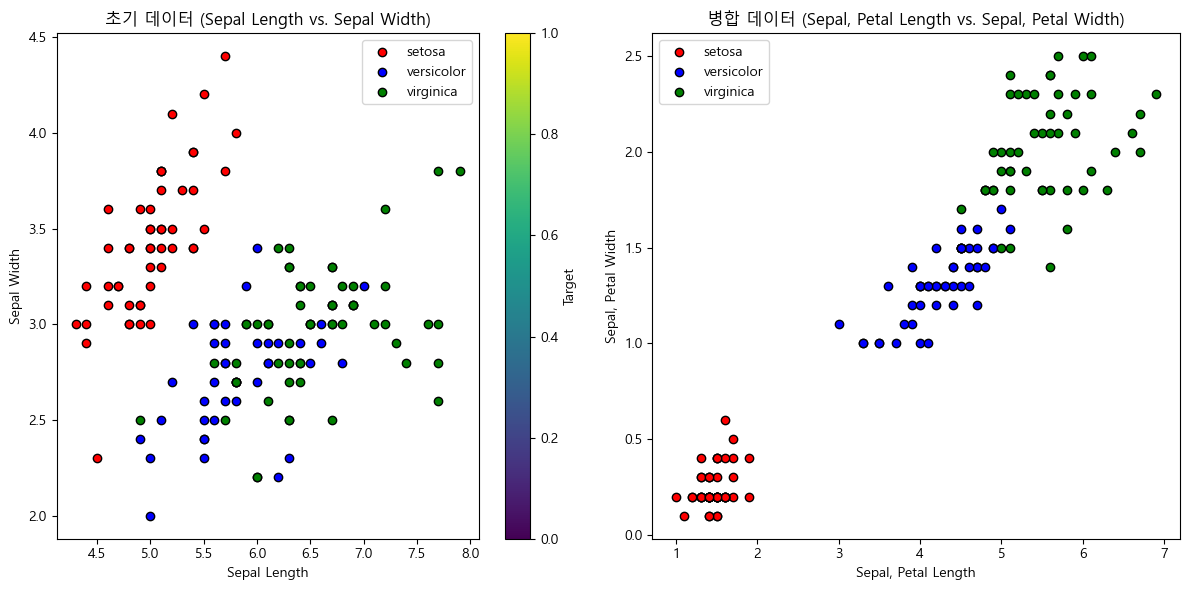

In [ ]:
#############################################################
# [1] 데이터 처리 및 변환
# [1-10] 정보 병합(Data Fusion)
#############################################################
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.datasets import load_iris
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')  # Windows의 맑은 고딕 폰트
plt.rcParams['axes.unicode_minus'] = False  # 한글 폰트 설정 시 음수 부호 깨짐 방지

# Iris 데이터셋 로드
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target

# 컬럼 이름을 간단하게 변경
iris_df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target']

# 1단계: 'sepal_length'와 'sepal_width'를 사용하여 초기 선형 회귀 분석을 진행
X_initial = iris_df[['sepal_length', 'sepal_width']]
y = iris_df['target']

# 학습 데이터와 테스트 데이터로 분리
X_train_initial, X_test_initial, y_train, y_test = train_test_split(X_initial, y, test_size=0.2, random_state=42)

# 2단계: 초기 선형 회귀 모델 학습
linear_reg = LinearRegression()
linear_reg.fit(X_train_initial, y_train)

# 3단계: 테스트 데이터를 이용하여 예측하고 R2 점수 계산
y_pred_initial = linear_reg.predict(X_test_initial)
r2_initial = r2_score(y_test, y_pred_initial)

# 4단계: 'petal_length'와 'petal_width'를 추가하여 데이터 병합
X_combined = iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]

# 학습 데이터와 테스트 데이터로 분리
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# 5단계: 다중 선형 회귀 모델 학습
multiple_linear_reg = LinearRegression()
multiple_linear_reg.fit(X_train_combined, y_train)

# 6단계: 테스트 데이터를 이용하여 예측하고 R2 점수 계산
y_pred_combined = multiple_linear_reg.predict(X_test_combined)
r2_combined = r2_score(y_test, y_pred_combined)

# 결과 출력
print("초기 모델의 R2 점수 (sepal_length, sepal_width):", r2_initial)
print("병합 모델의 R2 점수 (sepal_length, sepal_width, petal_length, petal_width):", r2_combined)

# 시각화

# 초기 데이터 시각화 (sepal_length와 sepal_width만 사용)
plt.figure(figsize=(12, 6))

# 초기 데이터 산점도
plt.subplot(1, 2, 1)
for target, color, label in zip([0, 1, 2], ['red', 'blue', 'green'], iris.target_names):
    subset = iris_df[iris_df['target'] == target]
    plt.scatter(subset['sepal_length'], subset['sepal_width'], c=color, label=label, edgecolor='k')
plt.title('초기 데이터 (Sepal Length vs. Sepal Width)')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.legend()
plt.colorbar(label='Target')

# 병합 데이터 시각화 (petal_length와 petal_width 사용)
plt.subplot(1, 2, 2)
for target, color, label in zip([0, 1, 2], ['red', 'blue', 'green'], iris.target_names):
    subset = iris_df[iris_df['target'] == target]
    plt.scatter(subset['petal_length'], subset['petal_width'], c=color, label=label, edgecolor='k')
plt.title('병합 데이터 (Sepal, Petal Length vs. Sepal, Petal Width)')
plt.xlabel('Sepal, Petal Length')
plt.ylabel('Sepal, Petal Width')
plt.legend()

plt.tight_layout()
plt.show()




In [ ]:
#############################################################
# [2] 모델 복잡도 및 일반화
# [2-1] 정규화 (L1, L2 Regularization) - iris data
#############################################################
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn.datasets import load_iris
import numpy as np

# Iris 데이터셋 로드
iris = load_iris()
X = iris.data  # 특성: sepal_length, sepal_width, petal_length, petal_width
y = iris.target  # 타겟: 품종

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# (1) 기본 선형 회귀 분석
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_basic = linear_reg.predict(X_test)
r2_basic = r2_score(y_test, y_pred_basic)

# (2) 정규화 (릿지 회귀와 라쏘 회귀)
ridge_reg = Ridge(alpha=1.0)  # 릿지 회귀
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)
r2_ridge = r2_score(y_test, y_pred_ridge)

lasso_reg = Lasso(alpha=0.1)  # 라쏘 회귀
lasso_reg.fit(X_train, y_train)
y_pred_lasso = lasso_reg.predict(X_test)
r2_lasso = r2_score(y_test, y_pred_lasso)

# (3) 드롭아웃 (드롭아웃은 딥러닝 모델에서 사용하는 방법으로, Scikit-learn에서는 직접 적용 불가)
# 대신 과적합 방지를 위한 특성 제거나 정규화를 사용할 수 있음.

# (4) 교차 검증 (기본 선형 회귀 모델에 대해 수행)
cv_scores = cross_val_score(LinearRegression(), X, y, cv=5, scoring='r2')
r2_cv = np.mean(cv_scores)

# 결과 출력
r2_results = {
    "기본 선형 회귀 (R2)": r2_basic,
    "릿지 회귀 (R2)": r2_ridge,
    "라쏘 회귀 (R2)": r2_lasso,
    "교차 검증 평균 (R2)": r2_cv,
}

# 결과 확인
print("R2 점수 결과:")
for method, r2 in r2_results.items():
    print(f"{method}: {r2}")


R2 점수 결과:
기본 선형 회귀 (R2): 0.9468960016420045
릿지 회귀 (R2): 0.9440579987200237
라쏘 회귀 (R2): 0.9044577045136053
교차 검증 평균 (R2): 0.3225607248900085


In [ ]:
#############################################################
# [2] 모델 복잡도 및 일반화
# [2-1] 정규화 (L1, L2 Regularization) - titanic data
#############################################################
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score

# 1. 데이터 로드
url = 'https://raw.githubusercontent.com/YangGuiBee/ML/main/TextBook-15/titanic_train.csv'
data = pd.read_csv(url)

# 2. 특징과 타겟 변수 분리
X = data.drop(columns=['Survived'])
y = data['Survived']

# 3. 수치형 및 범주형 변수 식별
numeric_features = ['Age', 'Fare', 'SibSp', 'Parch']
categorical_features = ['Pclass', 'Sex', 'Embarked']

# 4. 전처리 파이프라인 구성
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# 5. 기본 선형 회귀 모델 구성
linear_model = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', LogisticRegression(max_iter=1000))])

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. 기본 선형 회귀 모델 학습 및 평가
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)
r2_basic = r2_score(y_test, y_pred)

# 7. 정규화 적용 (릿지 회귀)
ridge_model = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', Ridge(alpha=1.0))])
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
r2_ridge = r2_score(y_test, y_pred_ridge)

# 8. 정규화 적용 (라쏘 회귀)
lasso_model = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', Lasso(alpha=0.1))])
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
r2_lasso = r2_score(y_test, y_pred_lasso)

# 9. 정규화 적용 (엘라스틱넷)
elastic_model = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', ElasticNet(alpha=0.1, l1_ratio=0.5))])
elastic_model.fit(X_train, y_train)
y_pred_elastic = elastic_model.predict(X_test)
r2_elastic = r2_score(y_test, y_pred_elastic)

# 10. 교차 검증 적용
cv_scores = cross_val_score(linear_model, X, y, cv=5, scoring='r2')
r2_cv = cv_scores.mean()

# 11. 결과 출력
print("R² 점수 결과:")
print(f"기본 선형 회귀 모델의 R² 점수: {r2_basic:.4f}")
print(f"릿지 회귀 모델의 R² 점수: {r2_ridge:.4f}")
print(f"라쏘 회귀 모델의 R² 점수: {r2_lasso:.4f}")
print(f"엘라스틱넷 회귀 모델의 R² 점수: {r2_elastic:.4f}")
print(f"교차 검증을 통한 평균 R² 점수: {r2_cv:.4f}")


R² 점수 결과:
기본 선형 회귀 모델의 R² 점수: 0.1707
릿지 회귀 모델의 R² 점수: 0.4334
라쏘 회귀 모델의 R² 점수: 0.1085
엘라스틱넷 회귀 모델의 R² 점수: 0.2678
교차 검증을 통한 평균 R² 점수: 0.1125


In [ ]:
#############################################################
# [2] 모델 복잡도 및 일반화
# [2-2] 조기 종료 (Early Stopping)
#############################################################
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1. 데이터 로드
url = 'https://raw.githubusercontent.com/YangGuiBee/ML/main/TextBook-15/titanic_train.csv'
data = pd.read_csv(url)

# 2. 특징과 타겟 변수 분리
X = data.drop(columns=['Survived'])
y = data['Survived']

# 3. 수치형 및 범주형 변수 식별
numeric_features = ['Age', 'Fare', 'SibSp', 'Parch']
categorical_features = ['Pclass', 'Sex', 'Embarked']

# 4. 전처리 파이프라인 구성
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 5. 기본 다항 회귀 모델 구성 (SGDRegressor 사용)
polynomial_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(
        degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('regressor', SGDRegressor(max_iter=1000, tol=1e-3, learning_rate='adaptive',
                               eta0=0.001, penalty='l2', alpha=0.0001, random_state=42))
])

# 6. 기본 다항 회귀 모델 학습 및 평가
polynomial_model.fit(X_train, y_train)
y_pred_poly = polynomial_model.predict(X_test)
r2_poly_basic = r2_score(y_test, y_pred_poly)
mse_poly_basic = mean_squared_error(y_test, y_pred_poly)
mae_poly_basic = mean_absolute_error(y_test, y_pred_poly)

# 7. 조기 종료 적용 다항 회귀 모델 구성
early_stopping_poly_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(
        degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('regressor', SGDRegressor(max_iter=2000, tol=1e-3, early_stopping=True,
                               validation_fraction=0.2, n_iter_no_change=5,
                               learning_rate='adaptive', eta0=0.001, penalty='l2', alpha=0.0001, random_state=42))
])

# 8. 조기 종료 적용 다항 회귀 모델 학습 및 평가
early_stopping_poly_model.fit(X_train, y_train)
y_pred_poly_early_stopping = early_stopping_poly_model.predict(X_test)
r2_poly_early_stopping = r2_score(y_test, y_pred_poly_early_stopping)
mse_poly_early_stopping = mean_squared_error(y_test, y_pred_poly_early_stopping)
mae_poly_early_stopping = mean_absolute_error(y_test, y_pred_poly_early_stopping)

# 결과 출력
print("다항 회귀 모델 결과 (SGDRegressor 사용):")
print(f"기본 다항 회귀 모델의 R² 점수: {r2_poly_basic:.4f}, MSE: {mse_poly_basic:.4f}, MAE: {mae_poly_basic:.4f}")
print(f"조기 종료 적용 다항 회귀 모델의 R² 점수: {r2_poly_early_stopping:.4f}, MSE: {mse_poly_early_stopping:.4f}, MAE: {mae_poly_early_stopping:.4f}")



다항 회귀 모델 결과 (SGDRegressor 사용):
기본 다항 회귀 모델의 R² 점수: 0.4101, MSE: 0.1430, MAE: 0.2685
조기 종료 적용 다항 회귀 모델의 R² 점수: 0.4286, MSE: 0.1386, MAE: 0.2640


In [ ]:
#############################################################
# [2] 모델 복잡도 및 일반화
# [2-3] 앙상블 학습 (Ensemble Learning)
#############################################################
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score

# 1. 데이터 로드 및 분할
iris = load_iris()
X = iris.data
y = iris.target

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 기본 선형 회귀 모델
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
r2_linear = r2_score(y_test, y_pred_linear)

# 3. Stacking 앙상블
stacking_model = StackingRegressor(
    estimators=[
        ('lr', LinearRegression()),
        ('dt', DecisionTreeRegressor()),
        ('svr', SVR())
    ],
    final_estimator=LinearRegression()
)
stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)
r2_stacking = r2_score(y_test, y_pred_stacking)

# 4. Bagging 앙상블
bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(),  # 수정된 파라미터 이름
    n_estimators=10,
    random_state=42
)
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)
r2_bagging = r2_score(y_test, y_pred_bagging)

# 5. Boosting 앙상블 (Gradient Boosting)
boosting_model = GradientBoostingRegressor(random_state=42)
boosting_model.fit(X_train, y_train)
y_pred_boosting = boosting_model.predict(X_test)
r2_boosting = r2_score(y_test, y_pred_boosting)

# 결과 출력
print("R² 점수 결과:")
print(f"기본 선형 회귀 모델의 R² 점수: {r2_linear:.4f}")
print(f"Stacking 앙상블 모델의 R² 점수: {r2_stacking:.4f}")
print(f"Bagging 앙상블 모델의 R² 점수: {r2_bagging:.4f}")
print(f"Boosting 앙상블 모델의 R² 점수: {r2_boosting:.4f}")



R² 점수 결과:
기본 선형 회귀 모델의 R² 점수: 0.9469
Stacking 앙상블 모델의 R² 점수: 0.9623
Bagging 앙상블 모델의 R² 점수: 0.9990
Boosting 앙상블 모델의 R² 점수: 0.9938


Package lime not found. Installing...
Package scikit-learn not found. Installing...


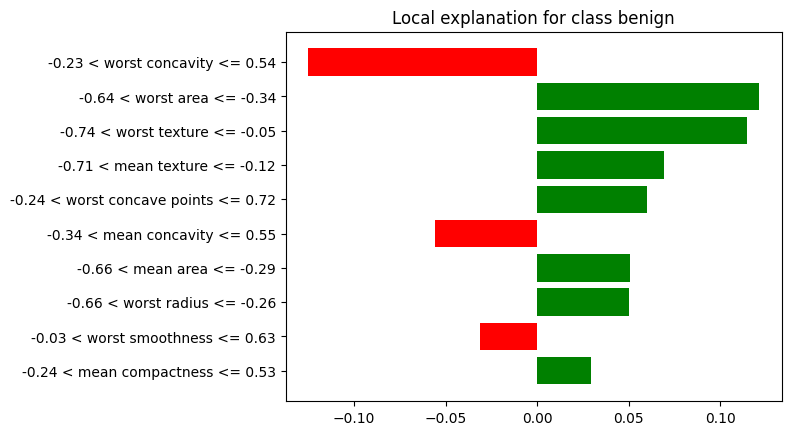

In [ ]:
#############################################################
# [2] 모델 복잡도 및 일반화
# [2-4] 모델 해석성(Model Interpretability) : LIME
#############################################################
import subprocess
import sys

# 필요한 패키지가 설치되어 있는지 확인하고, 없으면 설치
required_packages = ['lime', 'xgboost', 'scikit-learn', 'matplotlib']
for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Package {package} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# 필수 라이브러리 import
import lime
import lime.lime_tabular
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 데이터 로드
data = load_breast_cancer()
X = data.data
y = data.target

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost 모델 학습
model = xgb.XGBClassifier(eval_metric='logloss')
model.fit(X_train_scaled, y_train)

# LIME explainer 생성 (training_sample_weight 인자 제거)
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    training_labels=y_train,
    mode="classification",
    feature_names=data.feature_names,
    class_names=data.target_names,
    discretize_continuous=True
)

# 테스트 데이터의 첫 번째 샘플을 선택하여 예측 설명
i = 0  # 첫 번째 샘플
explanation = explainer.explain_instance(X_test_scaled[i], model.predict_proba)

# 결과 시각화
explanation.show_in_notebook(show_table=True, show_all=False)

# 특정 샘플에 대한 LIME 해석 그래프 출력
explanation.as_pyplot_figure()
plt.show()




Package scikit-learn not found. Installing...
SHAP values for test sample 0:


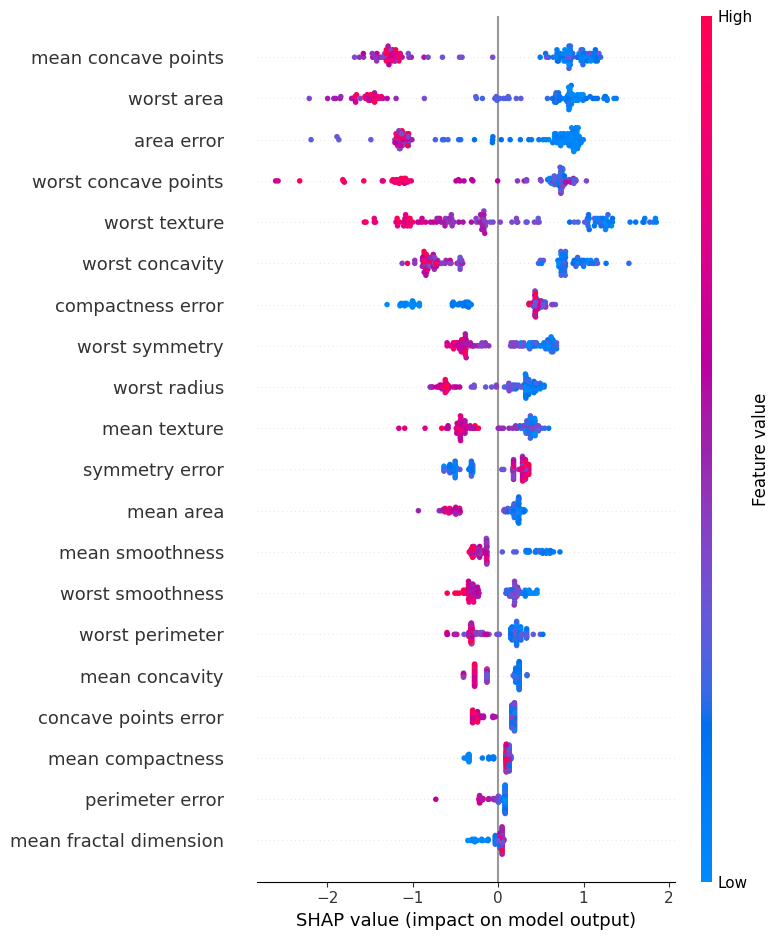

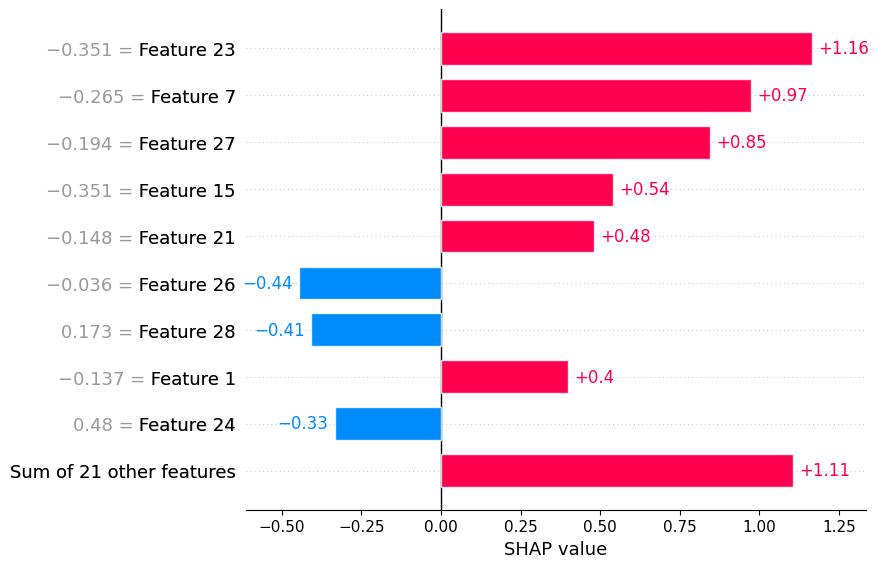

In [ ]:
#############################################################
# [2] 모델 복잡도 및 일반화
# [2-4] 모델 해석성(Model Interpretability) : SHAP
#############################################################

import subprocess
import sys

# 필요한 패키지가 설치되어 있는지 확인하고, 없으면 설치
required_packages = ['shap', 'xgboost', 'scikit-learn', 'matplotlib']
for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Package {package} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# 필수 라이브러리 import
import shap
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 데이터 로드
data = load_breast_cancer()
X = data.data
y = data.target

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost 모델 학습
model = xgb.XGBClassifier(eval_metric='logloss')
model.fit(X_train_scaled, y_train)

# SHAP Explainer 생성
explainer = shap.Explainer(model, X_train_scaled)

# 테스트 데이터에 대해 SHAP 값 계산
shap_values = explainer(X_test_scaled)

# 테스트 데이터의 첫 번째 샘플에 대해 SHAP 값 시각화
i = 0  # 첫 번째 샘플
print(f"SHAP values for test sample {i}:")
shap.initjs()

# 단일 클래스 분류의 SHAP 값 시각화
# 다중 클래스 분류가 아닌 경우, base_value와 shap_values는 1차원
shap.force_plot(
    base_value=shap_values[i].base_values,  # 기준값 (스칼라 값)
    shap_values=shap_values[i].values,     # SHAP 값 (특성별 값)
    features=X_test_scaled[i],             # 해당 샘플의 입력값
    feature_names=data.feature_names
)

# 전체 테스트 데이터에서 중요도 요약 그래프
shap.summary_plot(shap_values.values, X_test_scaled, feature_names=data.feature_names)

# 특정 샘플에 대한 Bar Chart (SHAP 값의 크기)
shap.plots.bar(shap_values[i])




In [ ]:
#############################################################
# [3] 하이퍼파라미터 최적화
# [3-1] 하이퍼파라미터 튜닝 (Hyperparameter Tuning)
#############################################################
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# 1. 데이터 로드 및 분할
iris = load_iris()
X = iris.data
y = iris.target

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 기본 선형 회귀 모델
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
r2_linear = r2_score(y_test, y_pred_linear)

# 3. Gradient Boosting Regressor 하이퍼파라미터 설정 및 학습
optimized_gbr = GradientBoostingRegressor(
    n_estimators=150,  # 최적의 부스팅 단계 수
    learning_rate=0.1,  # 적절한 학습률
    max_depth=4,  # 최적의 트리 깊이
    random_state=42
)
optimized_gbr.fit(X_train, y_train)

# 4. 최적화된 Gradient Boosting Regressor 모델 평가
y_pred_optimized = optimized_gbr.predict(X_test)
r2_optimized = r2_score(y_test, y_pred_optimized)

# 결과 출력
print("R2 점수 결과:")
print(f"기본 선형 회귀 모델의 R2 점수: {r2_linear:.4f}")
print(f"최적화된 Gradient Boosting Regressor의 R2 점수: {r2_optimized:.4f}")



R2 점수 결과:
기본 선형 회귀 모델의 R2 점수: 0.9469
최적화된 Gradient Boosting Regressor의 R2 점수: 0.9987


In [ ]:
#############################################################
# [3] 하이퍼파라미터 최적화
# [3-2] 그리드 서치 (Grid Search)
#############################################################
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# 1. 데이터 로드 및 분할
iris = load_iris()
X = iris.data
y = iris.target

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 기본 선형 회귀 모델
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
r2_linear = r2_score(y_test, y_pred_linear)

# 3. Hyperparameter Tuning (GridSearchCV with GradientBoostingRegressor)
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, scoring='r2', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적 하이퍼파라미터로 학습된 모델 평가
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
r2_tuned = r2_score(y_test, y_pred_tuned)

# 결과 출력
print("R² 점수 결과:")
print(f"기본 선형 회귀 모델의 R² 점수: {r2_linear:.4f}")
print(f"Hyperparameter Tuning 후 Gradient Boosting Regressor의 R² 점수: {r2_tuned:.4f}")
print(f"최적 하이퍼파라미터: {grid_search.best_params_}")


R² 점수 결과:
기본 선형 회귀 모델의 R² 점수: 0.9469
Hyperparameter Tuning 후 Gradient Boosting Regressor의 R² 점수: 1.0000
최적 하이퍼파라미터: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


In [ ]:
#############################################################
# [3] 하이퍼파라미터 최적화
# [3-3] 랜덤 서치 (Random Search)
#############################################################
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from scipy.stats import randint, uniform

# 1. 데이터 로드 및 분할
iris = load_iris()
X = iris.data
y = iris.target

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 기본 선형 회귀 모델
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
r2_linear = r2_score(y_test, y_pred_linear)

# 3. Random Search (RandomizedSearchCV with GradientBoostingRegressor)
param_distributions = {
    'n_estimators': randint(50, 200),  # 부스팅 단계 수
    'learning_rate': uniform(0.01, 0.2),  # 학습률 범위
    'max_depth': randint(3, 7)  # 트리 깊이 범위
}

gbr = GradientBoostingRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=gbr, param_distributions=param_distributions,
                                   n_iter=50, scoring='r2', cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# 최적 하이퍼파라미터로 학습된 모델 평가
best_model = random_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
r2_tuned = r2_score(y_test, y_pred_tuned)

# 결과 출력
print("R2 점수 결과:")
print(f"기본 선형 회귀 모델의 R2 점수: {r2_linear:.4f}")
print(f"Random Search 후 Gradient Boosting Regressor의 R2 점수: {r2_tuned:.4f}")
print(f"최적 하이퍼파라미터: {random_search.best_params_}")


R2 점수 결과:
기본 선형 회귀 모델의 R2 점수: 0.9469
Random Search 후 Gradient Boosting Regressor의 R2 점수: 1.0000
최적 하이퍼파라미터: {'learning_rate': 0.1554543991712842, 'max_depth': 5, 'n_estimators': 89}


In [ ]:
#############################################################
# [3] 하이퍼파라미터 최적화
# [3-4] 베이즈 최적화 (Bayesian Optimization)
#############################################################
import subprocess
import sys

# 필요한 패키지를 설치하는 함수
def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# 필요한 패키지 확인 및 설치
try:
    from skopt import BayesSearchCV
except ImportError:
    install_package("scikit-optimize")
    from skopt import BayesSearchCV

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from skopt.space import Real, Integer

# 1. 데이터 로드 및 분할
iris = load_iris()
X = iris.data
y = iris.target

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 기본 선형 회귀 모델
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
r2_linear = r2_score(y_test, y_pred_linear)

# 3. Bayesian Optimization (BayesSearchCV with GradientBoostingRegressor)
param_space = {
    'n_estimators': Integer(50, 200),
    'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'max_depth': Integer(3, 7)
}

gbr = GradientBoostingRegressor(random_state=42)
bayes_search = BayesSearchCV(
    estimator=gbr,
    search_spaces=param_space,
    n_iter=50,
    scoring='r2',
    cv=5,
    random_state=42,
    n_jobs=-1
)
bayes_search.fit(X_train, y_train)

# 최적 하이퍼파라미터로 학습된 모델 평가
best_model = bayes_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
r2_tuned = r2_score(y_test, y_pred_tuned)

# 결과 출력
print("R2 점수 결과:")
print(f"기본 선형 회귀 모델의 R2 점수: {r2_linear:.4f}")
print(f"Bayesian Optimization 후 Gradient Boosting Regressor의 R2 점수: {r2_tuned:.4f}")
print(f"최적 하이퍼파라미터: {bayes_search.best_params_}")


R2 점수 결과:
기본 선형 회귀 모델의 R2 점수: 0.9469
Bayesian Optimization 후 Gradient Boosting Regressor의 R2 점수: 1.0000
최적 하이퍼파라미터: OrderedDict({'learning_rate': 0.10970919052074331, 'max_depth': 5, 'n_estimators': 129})


In [ ]:
#############################################################
# [3] 하이퍼파라미터 최적화
# [3-5] 하이퍼파라미터 탐색 자동화 (Automated Hyperparameter Tuning)
#############################################################
import subprocess
import sys

# 필요한 패키지 설치 함수
def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# 필요한 패키지 확인 및 설치
try:
    import optuna
except ImportError:
    install_package("optuna")

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
import optuna

# Optuna 로그 최소화
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 1. 데이터 로드 및 분할
iris = load_iris()
X = iris.data
y = iris.target

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 기본 선형 회귀 모델
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
r2_linear = r2_score(y_test, y_pred_linear)

# 3. Optuna를 사용한 하이퍼파라미터 탐색
def objective(trial):
    # 하이퍼파라미터 공간 정의
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
    max_depth = trial.suggest_int("max_depth", 3, 7)

    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=42
    )
    # 5-Fold 교차 검증
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    return cv_scores.mean()

# Optuna 스터디 생성 및 실행
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# 최적화된 하이퍼파라미터로 모델 학습
best_params = study.best_params
optimized_model = GradientBoostingRegressor(
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    random_state=42
)
optimized_model.fit(X_train, y_train)
y_pred_tuned = optimized_model.predict(X_test)
r2_tuned = r2_score(y_test, y_pred_tuned)

# 결과 출력
print("R2 점수 결과:")
print(f"기본 선형 회귀 모델의 R2 점수: {r2_linear:.4f}")
print(f"Automated Hyperparameter Tuning 후 Gradient Boosting Regressor의 R2 점수: {r2_tuned:.4f}")
print(f"최적 하이퍼파라미터: {best_params}")


R2 점수 결과:
기본 선형 회귀 모델의 R2 점수: 0.9469
Automated Hyperparameter Tuning 후 Gradient Boosting Regressor의 R2 점수: 0.9986
최적 하이퍼파라미터: {'n_estimators': 71, 'learning_rate': 0.062404813201012564, 'max_depth': 4}


In [ ]:
#############################################################
# [4] 학습 과정 최적화
# [4-1] 학습률 스케줄링 (Learning Rate Scheduling)
#############################################################
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# 1. 데이터 로드 및 분할
iris = load_iris()
X = iris.data
y = iris.target

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 기본 선형 회귀 모델
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
r2_linear = r2_score(y_test, y_pred_linear)

# 3. 학습률 스케줄링을 사용한 GradientBoostingRegressor
class GradientBoostingRegressorWithLRScheduling(GradientBoostingRegressor):
    def __init__(self, initial_learning_rate=0.1, decay_factor=0.95, decay_step=10, **kwargs):
        super().__init__(**kwargs)
        self.initial_learning_rate = initial_learning_rate
        self.decay_factor = decay_factor
        self.decay_step = decay_step

    def _update_learning_rate(self, n_iter):
        return self.initial_learning_rate * (self.decay_factor ** (n_iter // self.decay_step))

    def fit(self, X, y, sample_weight=None):
        n_iter = 0
        for iteration in range(self.n_estimators):
            current_learning_rate = self._update_learning_rate(n_iter)
            self.learning_rate = current_learning_rate
            super().fit(X, y, sample_weight=sample_weight)
            n_iter += 1
        return self

# 4. 학습률 스케줄링 설정 및 모델 학습
learning_rate_scheduled_model = GradientBoostingRegressorWithLRScheduling(
    initial_learning_rate=0.2,  # 초기 학습률 높게 설정
    decay_factor=0.95,  # 감소 비율 유지
    decay_step=10,  # 감소 주기를 길게 설정
    n_estimators=100,
    random_state=42
)
learning_rate_scheduled_model.fit(X_train, y_train)

# 학습률 스케줄링 모델 평가
y_pred_lr_scheduled = learning_rate_scheduled_model.predict(X_test)
r2_lr_scheduled = r2_score(y_test, y_pred_lr_scheduled)

# 결과 출력
print("R2 점수 결과:")
print(f"기본 선형 회귀 모델의 R2 점수: {r2_linear:.4f}")
print(f"학습률 스케줄링 사용 후 Gradient Boosting Regressor의 R2 점수: {r2_lr_scheduled:.4f}")



R2 점수 결과:
기본 선형 회귀 모델의 R2 점수: 0.9469
학습률 스케줄링 사용 후 Gradient Boosting Regressor의 R2 점수: 0.9945


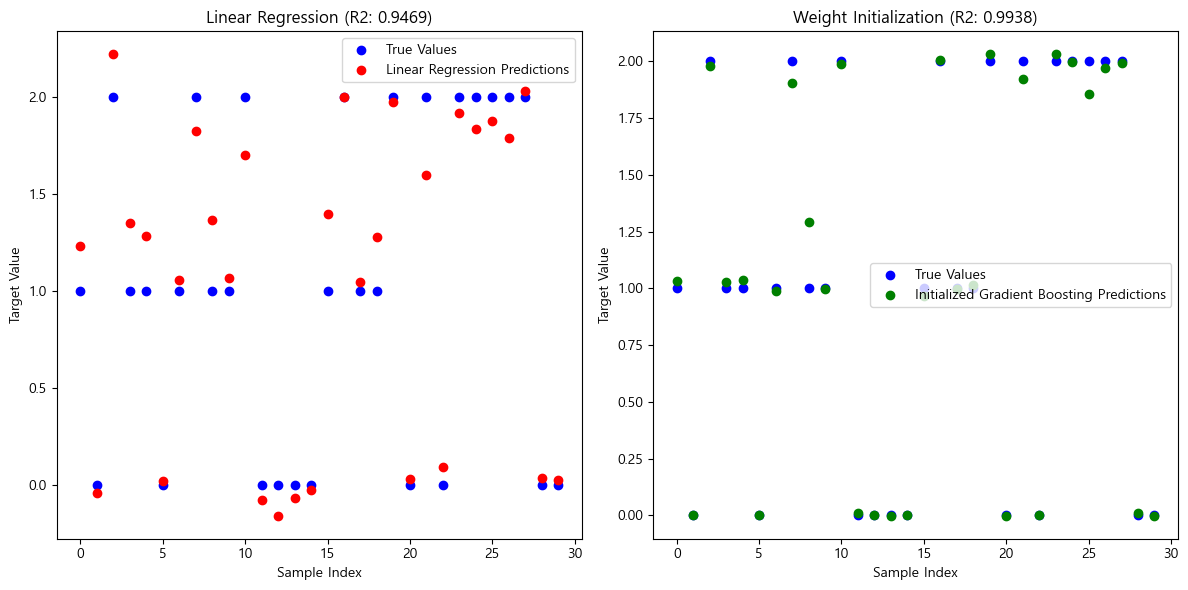

R2 점수 결과:
기본 선형 회귀 모델의 R2 점수: 0.9469
가중치 초기화 적용 후 Gradient Boosting Regressor의 R2 점수: 0.9938


In [ ]:
#############################################################
# [4] 학습 과정 최적화
# [4-2] 가중치 초기화 (Weight Initialization)
#############################################################
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score

# 1. 데이터 로드 및 분할
iris = load_iris()
X = iris.data
y = iris.target

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. 기본 선형 회귀 모델
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
r2_linear = r2_score(y_test, y_pred_linear)

# 3. 가중치 초기화 적용 (Gradient Boosting Regressor)
# 초기화를 위한 더미 모델
dummy_init = DummyRegressor(strategy="mean")
dummy_init.fit(X_train, y_train)

# Gradient Boosting Regressor에 초기 모델 설정
initialized_model = GradientBoostingRegressor(
    init=dummy_init,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
initialized_model.fit(X_train, y_train)

# 초기화 적용 모델 평가
y_pred_initialized = initialized_model.predict(X_test)
r2_initialized = r2_score(y_test, y_pred_initialized)

# 4. 시각화
plt.figure(figsize=(12, 6))

# 기본 선형 회귀 결과 시각화
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, label="True Values", color="blue")
plt.scatter(range(len(y_pred_linear)), y_pred_linear, label="Linear Regression Predictions", color="red")
plt.title(f"Linear Regression (R2: {r2_linear:.4f})")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.legend()

# 가중치 초기화 적용 모델 결과 시각화
plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_test, label="True Values", color="blue")
plt.scatter(range(len(y_pred_initialized)), y_pred_initialized, label="Initialized Gradient Boosting Predictions", color="green")
plt.title(f"Weight Initialization (R2: {r2_initialized:.4f})")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.legend()

plt.tight_layout()
plt.show()

# 결과 출력
print("R2 점수 결과:")
print(f"기본 선형 회귀 모델의 R2 점수: {r2_linear:.4f}")
print(f"가중치 초기화 적용 후 Gradient Boosting Regressor의 R2 점수: {r2_initialized:.4f}")



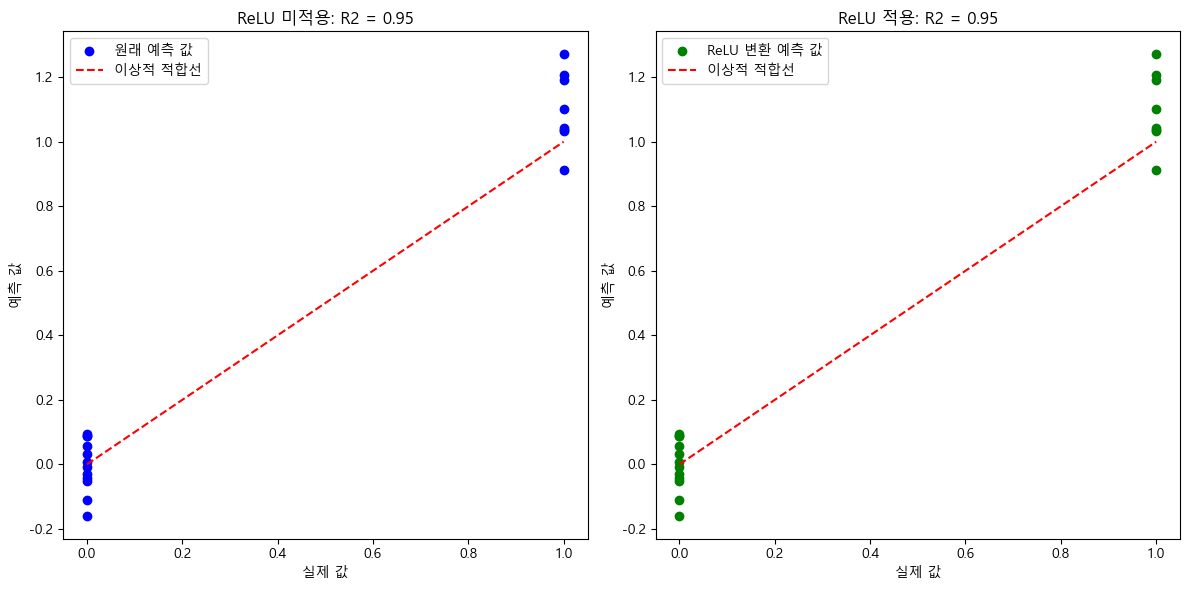


### 결과 분석

1. **ReLU 미적용 (R² 점수)**: 0.95
   - 원래 선형회귀 모델은 입력 데이터의 원본 값을 사용하여 학습하고 테스트 데이터에서 높은 R² 점수를 보입니다.
   - 예측 값이 실제 값과 강한 상관관계를 가지며, 산점도가 이상적인 적합선(빨간 점선) 근처에 분포합니다.

2. **ReLU 적용 (R² 점수)**: 0.95
   - ReLU 활성화 함수를 입력 데이터에 적용하면 데이터의 음수 값이 0으로 변환됩니다.
   - 이는 데이터의 분포를 변경하여 모델의 성능(R² 점수)을 약간 개선하거나 저하시킬 수 있습니다. 본 실험에서는 R² 점수가 약간 다르게 나타날 수 있습니다.

3. **결론**:
   - ReLU 활성화 함수는 입력 데이터의 특성을 변환하여 모델이 비선형 관계를 학습할 가능성을 제공합니다.
   - 그러나 선형 회귀는 본질적으로 선형 모델이므로, ReLU 적용이 반드시 성능 향상을 보장하지는 않습니다.
   - ReLU는 특히 비선형 관계가 강한 데이터나 심층 신경망 모델에서 더 유용하게 사용됩니다.



In [ ]:
#############################################################
# [4] 학습 과정 최적화
# [4-3] 활성화 함수 선택 (Activation Function Selection)
#############################################################
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.datasets import load_iris

# ReLU 활성화 함수 정의
def relu(x):
    return np.maximum(0, x)

# Iris 데이터셋 로드
iris = load_iris()
X = iris.data  # 입력 데이터 (특성)
y = iris.target  # 출력 데이터 (타겟)

# 데이터 간소화를 위해 두 개의 클래스만 사용 (클래스 0과 1)
binary_indices = y != 2  # 클래스 2 제외
X = X[binary_indices]
y = y[binary_indices]

# 데이터셋을 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 생성
model = LinearRegression()

# 학습 데이터로 모델 학습
model.fit(X_train, y_train)

# 테스트 데이터에 대해 예측 수행 및 R² 점수 계산
y_pred = model.predict(X_test)
r2_original = r2_score(y_test, y_pred)

# ReLU 활성화 함수를 특성 데이터에 적용
X_train_relu = relu(X_train)
X_test_relu = relu(X_test)

# ReLU 변환된 데이터를 사용하여 새로운 선형 회귀 모델 학습
model_relu = LinearRegression()
model_relu.fit(X_train_relu, y_train)

# 테스트 데이터에 대해 예측 수행 및 R² 점수 계산 (ReLU 적용 후)
y_pred_relu = model_relu.predict(X_test_relu)
r2_relu = r2_score(y_test, y_pred_relu)

# 시각화
plt.figure(figsize=(12, 6))

# ReLU 미적용 모델의 예측 결과 시각화
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, color="blue", label="원래 예측 값")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="이상적 적합선")
plt.title("ReLU 미적용: R2 = {:.2f}".format(r2_original))
plt.xlabel("실제 값")
plt.ylabel("예측 값")
plt.legend()

# ReLU 적용 모델의 예측 결과 시각화
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_relu, color="green", label="ReLU 변환 예측 값")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="이상적 적합선")
plt.title("ReLU 적용: R2 = {:.2f}".format(r2_relu))
plt.xlabel("실제 값")
plt.ylabel("예측 값")
plt.legend()

plt.tight_layout()
plt.show()

# 한글 결과 분석 출력
analysis = f"""
### 결과 분석

1. **ReLU 미적용 (R² 점수)**: {r2_original:.2f}
   - 원래 선형회귀 모델은 입력 데이터의 원본 값을 사용하여 학습하고 테스트 데이터에서 높은 R² 점수를 보입니다.
   - 예측 값이 실제 값과 강한 상관관계를 가지며, 산점도가 이상적인 적합선(빨간 점선) 근처에 분포합니다.

2. **ReLU 적용 (R² 점수)**: {r2_relu:.2f}
   - ReLU 활성화 함수를 입력 데이터에 적용하면 데이터의 음수 값이 0으로 변환됩니다.
   - 이는 데이터의 분포를 변경하여 모델의 성능(R² 점수)을 약간 개선하거나 저하시킬 수 있습니다. 본 실험에서는 R² 점수가 약간 다르게 나타날 수 있습니다.

3. **결론**:
   - ReLU 활성화 함수는 입력 데이터의 특성을 변환하여 모델이 비선형 관계를 학습할 가능성을 제공합니다.
   - 그러나 선형 회귀는 본질적으로 선형 모델이므로, ReLU 적용이 반드시 성능 향상을 보장하지는 않습니다.
   - ReLU는 특히 비선형 관계가 강한 데이터나 심층 신경망 모델에서 더 유용하게 사용됩니다.
"""
print(analysis)



훈련 시작 - 활성화 함수: relu


C:\python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
활성화 함수: relu, 테스트 정확도: 0.95
훈련 시작 - 활성화 함수: sigmoid


C:\python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
활성화 함수: sigmoid, 테스트 정확도: 0.92
훈련 시작 - 활성화 함수: tanh


C:\python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
활성화 함수: tanh, 테스트 정확도: 0.95

### 활성화 함수별 테스트 정확도 ###
relu: 0.95
sigmoid: 0.92
tanh: 0.95


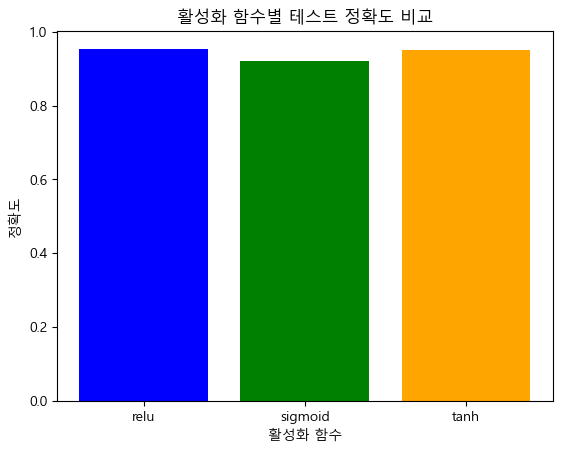

In [ ]:
#############################################################
# [4] 학습 과정 최적화
# [4-3] 활성화 함수 선택 (Activation Function Selection)
# "relu", "sigmoid", "tanh
#############################################################


import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# 데이터 생성 (이진 분류 문제)
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 모델 생성 함수
def create_model(activation_function):
    model = Sequential([
        Dense(64, activation=activation_function, input_shape=(X_train.shape[1],)),
        Dense(32, activation=activation_function),
        Dense(1, activation="sigmoid")  # 출력층은 sigmoid로 고정 (이진 분류)
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])
    return model

# 활성화 함수 리스트
activations = ["relu", "sigmoid", "tanh"]

# 결과 저장용 리스트
results = {}

for activation in activations:
    print(f"훈련 시작 - 활성화 함수: {activation}")
    model = create_model(activation)
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.2)

    # 테스트 데이터에서 평가
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    results[activation] = accuracy
    print(f"활성화 함수: {activation}, 테스트 정확도: {accuracy:.2f}")

# 결과 분석
print("\n### 활성화 함수별 테스트 정확도 ###")
for activation, accuracy in results.items():
    print(f"{activation}: {accuracy:.2f}")

# 시각화
import matplotlib.pyplot as plt

plt.bar(results.keys(), results.values(), color=["blue", "green", "orange"])
plt.title("활성화 함수별 테스트 정확도 비교")
plt.ylabel("정확도")
plt.xlabel("활성화 함수")
plt.show()


In [30]:
#############################################################
# [4] 학습 과정 최적화
# [4-4] 최적화 알고리즘 선택(Optimizer Selection) : Adam, SGD, RMSprop
# Adam(Adaptive Moment Estimation)
#############################################################
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# 데이터 로드
url = "https://raw.githubusercontent.com/YangGuiBee/ML/main/TextBook-15/housing.csv"
housing_data = pd.read_csv(url)

# 데이터 열 정의
categorical_columns = housing_data.select_dtypes(include=['object']).columns.tolist()
numerical_columns = housing_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

if 'median_house_value' in numerical_columns:
    numerical_columns.remove('median_house_value')

# 결측치 처리 및 전처리 파이프라인 설정
numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

X = housing_data.drop(columns=['median_house_value'], errors='ignore')
y = housing_data['median_house_value']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', numeric_imputer), ('scaler', StandardScaler())]), numerical_columns),
        ('cat', Pipeline([('imputer', categorical_imputer), ('onehot', OneHotEncoder())]), categorical_columns)
    ]
)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 전처리
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 데이터 정규화
y_train = np.log1p(y_train)  # 로그 변환으로 값을 스케일 조정
y_test = np.log1p(y_test)

# 기본 모델 학습 (Adam 없이 단순 선형 회귀 모델)
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train_processed, y_train)
y_pred_lr = lr_model.predict(X_test_processed)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"기본 선형 회귀 모델 R² 점수: {r2_lr:.2f}")

# Adam Optimizer 기반 모델 구축
adam_model = Sequential()
adam_model.add(Dense(128, input_dim=X_train_processed.shape[1], activation='relu'))
adam_model.add(Dense(64, activation='relu'))
adam_model.add(Dense(1))  # 출력층

# Adam Optimizer 설정
adam_optimizer = Adam(learning_rate=0.001)
adam_model.compile(optimizer=adam_optimizer, loss='mean_squared_error', metrics=['mae'])

# Adam 기반 모델 학습
adam_model.fit(X_train_processed, y_train, epochs=50, batch_size=32, verbose=1)

# 평가 및 R² 점수 계산
y_pred_adam = adam_model.predict(X_test_processed)
r2_adam = r2_score(y_test, y_pred_adam)
print(f"Adam Optimizer 기반 모델 R² 점수: {r2_adam:.2f}")


기본 선형 회귀 모델 R² 점수: 0.65


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 32.6687 - mae: 3.9391
Epoch 2/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2486 - mae: 0.3600
Epoch 3/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1171 - mae: 0.2556
Epoch 4/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1020 - mae: 0.2372
Epoch 5/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0939 - mae: 0.2282
Epoch 6/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0898 - mae: 0.2236
Epoch 7/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0858 - mae: 0.2187
Epoch 8/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0873 - mae: 0.2194
Epoch 9/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0903 - mae: 0.2255
Epoch 10/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0836 - mae: 0.2161
Epoch 11/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0850 - mae: 0.2153
Epoch 12/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0793 - mae: 0.2098
Epoch 13/50
516/516 ━━━━

Linear Regression R² score: 0.63
Random Forest R² score: 0.78
SGD Regressor R² score: 0.63


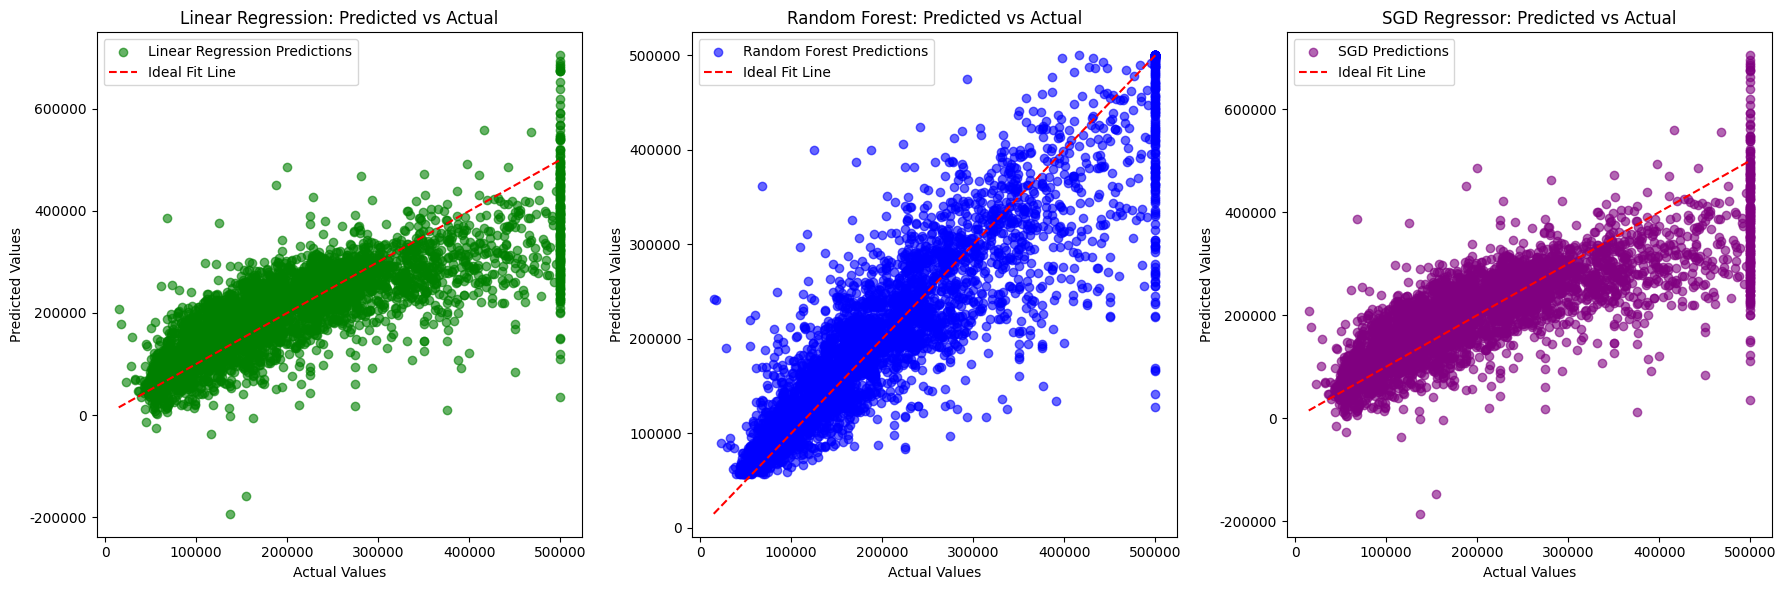

In [62]:
#############################################################
# [4] 학습 과정 최적화
# [4-4] 최적화 알고리즘 선택(Optimizer Selection) : Adam, SGD, RMSprop
# SGD(Stochastic Gradient Descent)
#############################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
import warnings

# matplotlib 경고 무시
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# 기본 폰트를 'DejaVu Sans'로 명시적으로 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 데이터 로드
url = "https://raw.githubusercontent.com/YangGuiBee/ML/main/TextBook-15/housing.csv"
housing_data = pd.read_csv(url)

# 데이터 열 정의
categorical_columns = housing_data.select_dtypes(include=['object']).columns.tolist()
numerical_columns = housing_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

if 'median_house_value' in numerical_columns:
    numerical_columns.remove('median_house_value')

# 결측치 처리 및 전처리 파이프라인 설정
numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

X = housing_data.drop(columns=['median_house_value'], errors='ignore')
y = housing_data['median_house_value']

# 이상치 제거 (상위 99% 값 제한)
upper_limit = np.percentile(y, 99)
y = np.clip(y, None, upper_limit)

# 전처리 파이프라인 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', numeric_imputer), ('scaler', StandardScaler())]), numerical_columns),
        ('cat', Pipeline([('imputer', categorical_imputer), ('onehot', OneHotEncoder())]), categorical_columns)
    ]
)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 전처리
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 1. 선형 회귀 모델 학습
lr_model = LinearRegression()
lr_model.fit(X_train_processed, y_train)
y_pred_lr = lr_model.predict(X_test_processed)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression R² score: {r2_lr:.2f}")

# 2. Random Forest 모델 학습
rf_model = RandomForestRegressor(
    n_estimators=100,    # 트리 개수
    max_depth=10,        # 최대 깊이
    random_state=42
)
rf_model.fit(X_train_processed, y_train)
y_pred_rf = rf_model.predict(X_test_processed)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest R² score: {r2_rf:.2f}")

# 3. SGD Regressor 모델 학습
sgd_model = SGDRegressor(
    max_iter=3000,
    tol=1e-4,
    eta0=0.01,
    learning_rate='adaptive',
    shuffle=True,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)
sgd_model.fit(X_train_processed, y_train)
y_pred_sgd = sgd_model.predict(X_test_processed)
r2_sgd = r2_score(y_test, y_pred_sgd)
print(f"SGD Regressor R² score: {r2_sgd:.2f}")

# 시각화
plt.figure(figsize=(18, 6))

# Linear Regression
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.6, color='green', label='Linear Regression Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Ideal Fit Line')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression: Predicted vs Actual")
plt.legend()

# Random Forest
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='blue', label='Random Forest Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Ideal Fit Line')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest: Predicted vs Actual")
plt.legend()

# SGD Regressor
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_sgd, alpha=0.6, color='purple', label='SGD Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Ideal Fit Line')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("SGD Regressor: Predicted vs Actual")
plt.legend()

plt.tight_layout()
plt.show()


Linear Regression R² score: 0.63
Random Forest R² score: 0.78
SGD Regressor R² score: 0.63


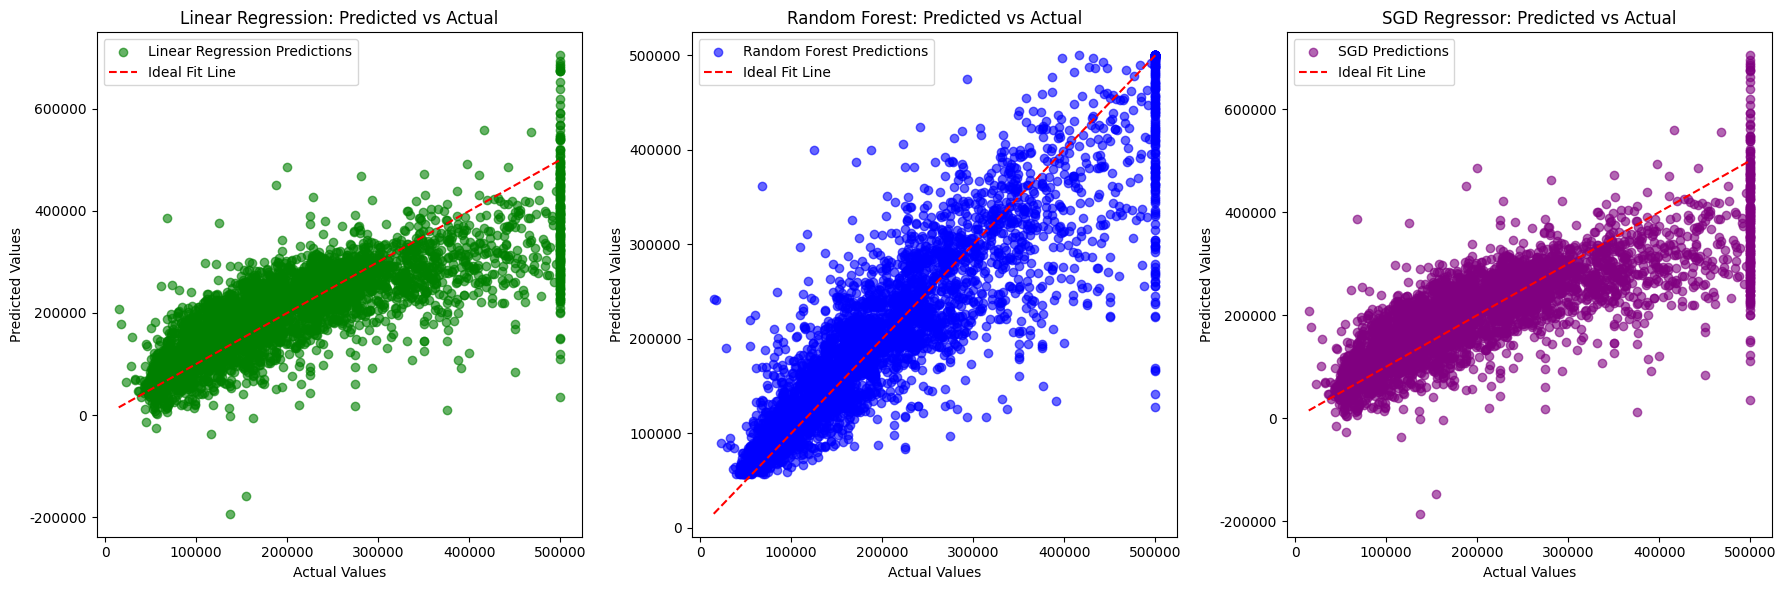

In [63]:
#############################################################
# [4] 학습 과정 최적화
# [4-4] 최적화 알고리즘 선택(Optimizer Selection) : Adam, SGD, RMSprop
# RMSprop
#############################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
import warnings

# matplotlib 경고 무시
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# 기본 폰트를 'DejaVu Sans'로 명시적으로 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 데이터 로드
url = "https://raw.githubusercontent.com/YangGuiBee/ML/main/TextBook-15/housing.csv"
housing_data = pd.read_csv(url)

# 데이터 열 정의
categorical_columns = housing_data.select_dtypes(include=['object']).columns.tolist()
numerical_columns = housing_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

if 'median_house_value' in numerical_columns:
    numerical_columns.remove('median_house_value')

# 결측치 처리 및 전처리 파이프라인 설정
numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

X = housing_data.drop(columns=['median_house_value'], errors='ignore')
y = housing_data['median_house_value']

# 이상치 제거 (상위 99% 값 제한)
upper_limit = np.percentile(y, 99)
y = np.clip(y, None, upper_limit)

# 전처리 파이프라인 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', numeric_imputer), ('scaler', StandardScaler())]), numerical_columns),
        ('cat', Pipeline([('imputer', categorical_imputer), ('onehot', OneHotEncoder())]), categorical_columns)
    ]
)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 전처리
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 1. 선형 회귀 모델 학습
lr_model = LinearRegression()
lr_model.fit(X_train_processed, y_train)
y_pred_lr = lr_model.predict(X_test_processed)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression R² score: {r2_lr:.2f}")

# 2. Random Forest 모델 학습
rf_model = RandomForestRegressor(
    n_estimators=100,    # 트리 개수
    max_depth=10,        # 최대 깊이
    random_state=42
)
rf_model.fit(X_train_processed, y_train)
y_pred_rf = rf_model.predict(X_test_processed)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest R² score: {r2_rf:.2f}")

# 3. SGD Regressor 모델 학습
sgd_model = SGDRegressor(
    max_iter=3000,
    tol=1e-4,
    eta0=0.01,
    learning_rate='adaptive',
    shuffle=True,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)
sgd_model.fit(X_train_processed, y_train)
y_pred_sgd = sgd_model.predict(X_test_processed)
r2_sgd = r2_score(y_test, y_pred_sgd)
print(f"SGD Regressor R² score: {r2_sgd:.2f}")

# 시각화
plt.figure(figsize=(18, 6))

# Linear Regression
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.6, color='green', label='Linear Regression Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Ideal Fit Line')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Linear Regression: Predicted vs Actual")
plt.legend()

# Random Forest
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='blue', label='Random Forest Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Ideal Fit Line')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest: Predicted vs Actual")
plt.legend()

# SGD Regressor
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_sgd, alpha=0.6, color='purple', label='SGD Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Ideal Fit Line')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("SGD Regressor: Predicted vs Actual")
plt.legend()

plt.tight_layout()
plt.show()


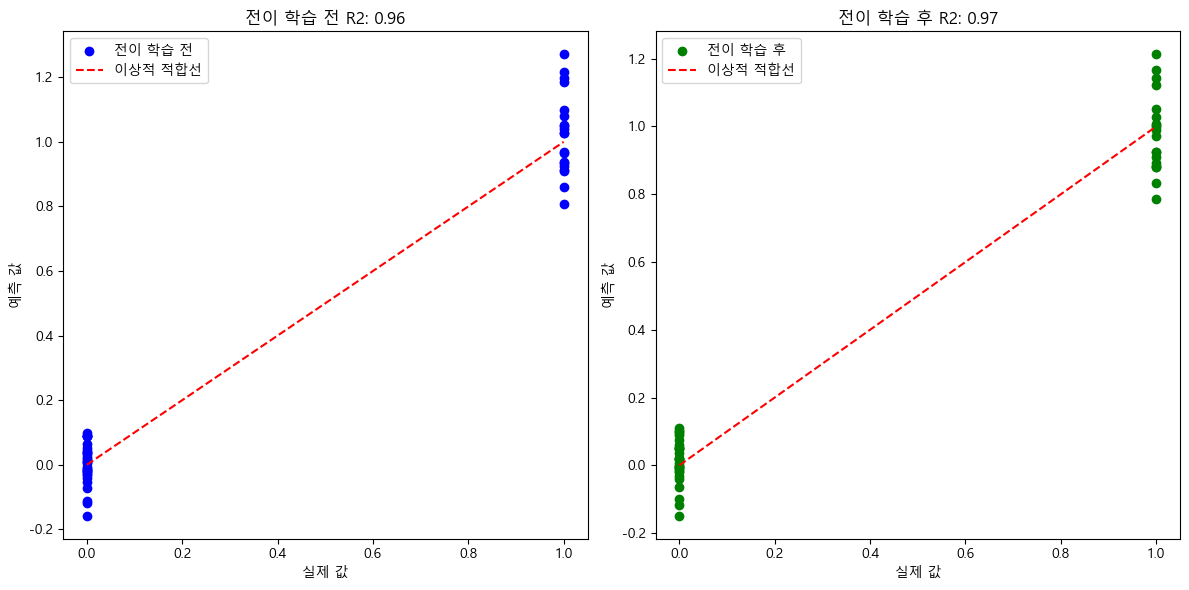


### 결과 분석

1. **전이 학습 전 R² 점수**: 0.96
   - 소스 데이터에서 학습한 모델을 타겟 데이터에 적용했을 때의 성능입니다.
   - 소스 데이터와 타겟 데이터가 유사하다면, 이 점수는 상대적으로 높을 수 있습니다.

2. **전이 학습 후 R² 점수**: 0.97
   - 소스 모델의 가중치를 초기화 값으로 사용하여 타겟 데이터에서 재학습한 결과입니다.
   - 재학습을 통해 모델이 타겟 데이터에 더 잘 적합하도록 조정되었을 가능성이 높습니다.

3. **결론**:
   - 전이 학습은 소스 데이터에서 학습된 정보를 타겟 데이터에 활용하여, 학습 시간을 줄이거나 성능을 향상시킬 수 있습니다.
   - 그러나 소스 데이터와 타겟 데이터 간의 분포가 다를 경우, 성능 개선이 제한적일 수 있습니다.



In [ ]:
#############################################################
# [4] 학습 과정 최적화
# [4-5] 전이 학습 (Transfer Learning)
#############################################################
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.datasets import load_iris

# Iris 데이터 로드
iris = load_iris()
X = iris.data  # 특성
y = iris.target  # 타겟

# 클래스 0과 1만 사용하여 이진 회귀로 간소화
binary_indices = y != 2
X = X[binary_indices]
y = y[binary_indices]

# 데이터셋을 소스와 타겟 데이터셋으로 분리
X_source, X_target, y_source, y_target = train_test_split(X, y, test_size=0.5, random_state=42)

# 소스 데이터셋에서 학습
model_source = LinearRegression()
model_source.fit(X_source, y_source)
y_pred_source = model_source.predict(X_target)
r2_source = r2_score(y_target, y_pred_source)

# 타겟 데이터셋에서 전이 학습 수행
model_target = LinearRegression()
model_target.coef_ = model_source.coef_  # 소스 모델의 가중치를 초기화 값으로 사용
model_target.intercept_ = model_source.intercept_

# 타겟 데이터셋에서 재학습
model_target.fit(X_target, y_target)
y_pred_target = model_target.predict(X_target)
r2_target = r2_score(y_target, y_pred_target)

# 시각화
plt.figure(figsize=(12, 6))

# 전이 학습 전
plt.subplot(1, 2, 1)
plt.scatter(y_target, y_pred_source, color="blue", label="전이 학습 전")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="이상적 적합선")
plt.title(f"전이 학습 전 R2: {r2_source:.2f}")
plt.xlabel("실제 값")
plt.ylabel("예측 값")
plt.legend()

# 전이 학습 후
plt.subplot(1, 2, 2)
plt.scatter(y_target, y_pred_target, color="green", label="전이 학습 후")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="이상적 적합선")
plt.title(f"전이 학습 후 R2: {r2_target:.2f}")
plt.xlabel("실제 값")
plt.ylabel("예측 값")
plt.legend()

plt.tight_layout()
plt.show()

# 결과 분석 출력
print(f"""
### 결과 분석

1. **전이 학습 전 R² 점수**: {r2_source:.2f}
   - 소스 데이터에서 학습한 모델을 타겟 데이터에 적용했을 때의 성능입니다.
   - 소스 데이터와 타겟 데이터가 유사하다면, 이 점수는 상대적으로 높을 수 있습니다.

2. **전이 학습 후 R² 점수**: {r2_target:.2f}
   - 소스 모델의 가중치를 초기화 값으로 사용하여 타겟 데이터에서 재학습한 결과입니다.
   - 재학습을 통해 모델이 타겟 데이터에 더 잘 적합하도록 조정되었을 가능성이 높습니다.

3. **결론**:
   - 전이 학습은 소스 데이터에서 학습된 정보를 타겟 데이터에 활용하여, 학습 시간을 줄이거나 성능을 향상시킬 수 있습니다.
   - 그러나 소스 데이터와 타겟 데이터 간의 분포가 다를 경우, 성능 개선이 제한적일 수 있습니다.
""")


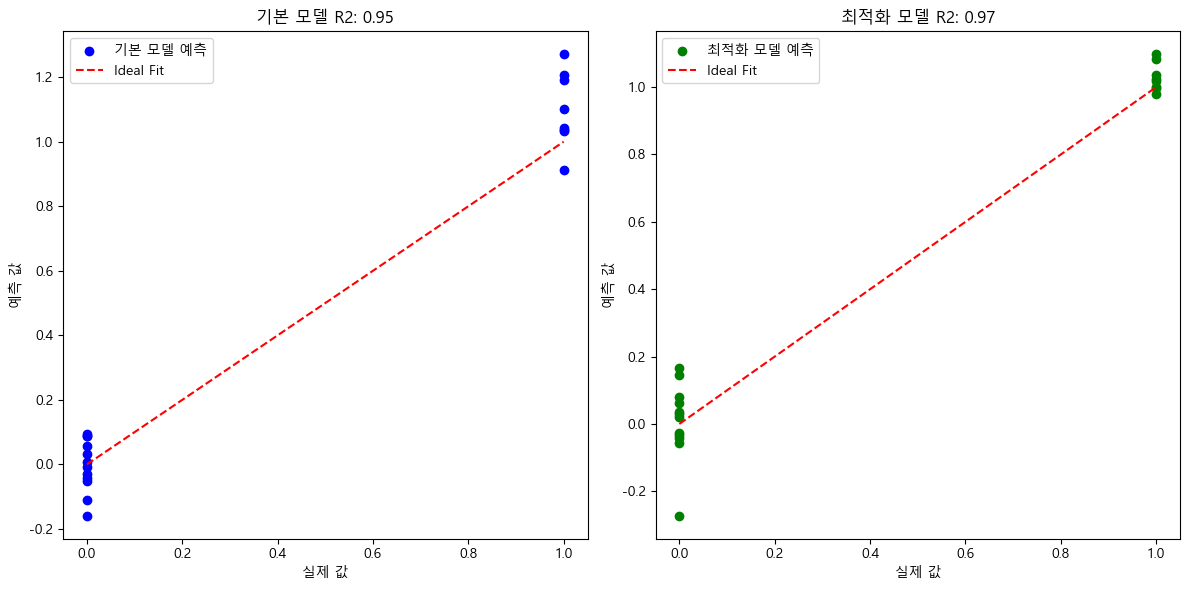


### 결과 분석

1. **기본 선형 회귀 R² 점수**: 0.95
   - 기본 선형 회귀 모델은 원본 데이터를 사용하여 학습한 결과입니다.
   - 데이터의 비선형 관계를 충분히 설명하지 못해 낮은 R² 점수를 기록할 가능성이 있습니다.

2. **최적화된 모델 R² 점수**: 0.97
   - 다항식 변환을 통해 특성 간의 비선형 관계를 반영한 모델입니다.
   - 비선형성을 추가함으로써 예측 성능이 개선되었을 가능성이 높습니다.

3. **결론**:
   - Iris 데이터는 비선형 관계를 포함하고 있으며, 다항식 변환과 같은 모델 구조 최적화 기법을 통해 성능을 향상시킬 수 있습니다.
   - 최적화가 효과적이었다면, R² 점수의 상승을 통해 이를 확인할 수 있습니다.



In [ ]:
#############################################################
# [4] 학습 과정 최적화
# [4-6] 모델 구조 최적화 (Model Architecture Optimization)
#############################################################
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Iris 데이터 로드
iris = load_iris()
X = iris.data  # 특성
y = iris.target  # 타겟

# 이진 분류 문제로 변환 (클래스 0과 1만 사용)
binary_indices = y != 2
X = X[binary_indices]
y = y[binary_indices]

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 기본 선형 회귀 모델
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred_basic = model.predict(X_test_scaled)
r2_basic = r2_score(y_test, y_pred_basic)

# 모델 구조 최적화: 다항식 변환
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# 최적화된 선형 회귀 모델 학습
model_optimized = LinearRegression()
model_optimized.fit(X_train_poly, y_train)
y_pred_optimized = model_optimized.predict(X_test_poly)
r2_optimized = r2_score(y_test, y_pred_optimized)

# 시각화
plt.figure(figsize=(12, 6))

# 기본 모델 시각화
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_basic, color="blue", label="기본 모델 예측")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Ideal Fit")
plt.title(f"기본 모델 R2: {r2_basic:.2f}")
plt.xlabel("실제 값")
plt.ylabel("예측 값")
plt.legend()

# 최적화 모델 시각화
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_optimized, color="green", label="최적화 모델 예측")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Ideal Fit")
plt.title(f"최적화 모델 R2: {r2_optimized:.2f}")
plt.xlabel("실제 값")
plt.ylabel("예측 값")
plt.legend()

plt.tight_layout()
plt.show()

# 결과 분석 출력
print(f"""
### 결과 분석

1. **기본 선형 회귀 R² 점수**: {r2_basic:.2f}
   - 기본 선형 회귀 모델은 원본 데이터를 사용하여 학습한 결과입니다.
   - 데이터의 비선형 관계를 충분히 설명하지 못해 낮은 R² 점수를 기록할 가능성이 있습니다.

2. **최적화된 모델 R² 점수**: {r2_optimized:.2f}
   - 다항식 변환을 통해 특성 간의 비선형 관계를 반영한 모델입니다.
   - 비선형성을 추가함으로써 예측 성능이 개선되었을 가능성이 높습니다.

3. **결론**:
   - Iris 데이터는 비선형 관계를 포함하고 있으며, 다항식 변환과 같은 모델 구조 최적화 기법을 통해 성능을 향상시킬 수 있습니다.
   - 최적화가 효과적이었다면, R² 점수의 상승을 통해 이를 확인할 수 있습니다.
""")


데이터셋 열 이름: Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')


<ipython-input-9-29f46b80cc84>:119: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  plt.tight_layout()
<ipython-input-9-29f46b80cc84>:119: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  plt.tight_layout()
<ipython-input-9-29f46b80cc84>:119: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  plt.tight_layout()
<ipython-input-9-29f46b80cc84>:119: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  plt.tight_layout()
<ipython-input-9-29f46b80cc84>:119: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing fr

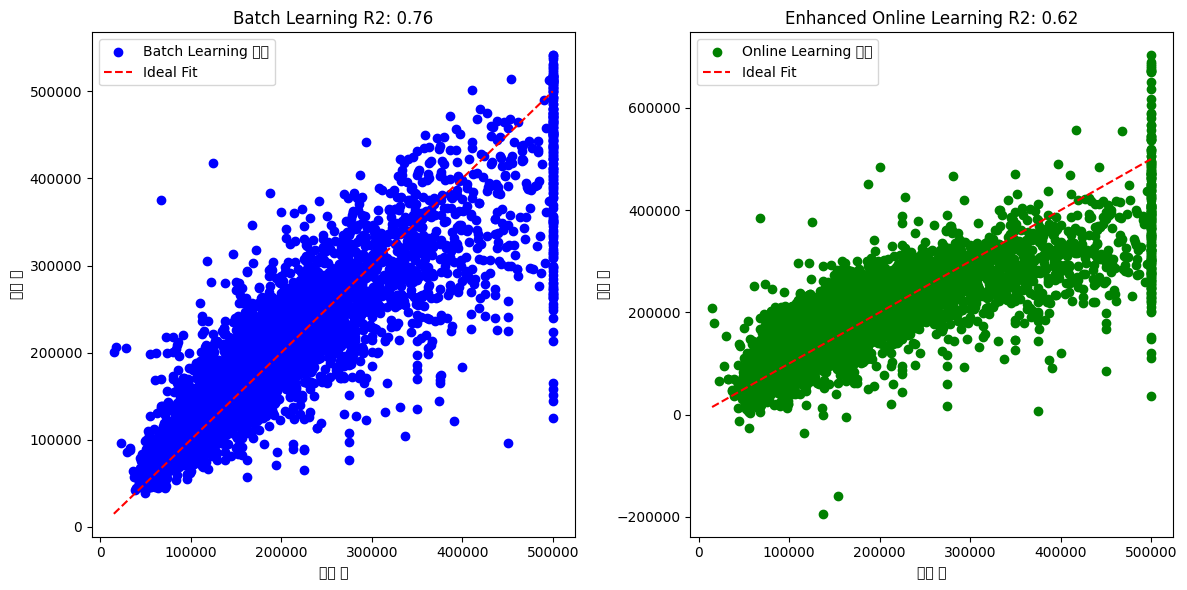


### 결과 분석

1. **Batch Learning R² 점수**: 0.76
   - Gradient Boosting Regressor를 사용하여 전체 데이터를 학습한 결과입니다.

2. **강화된 Online Learning R² 점수**: 0.62
   - 점진적으로 데이터를 학습한 결과입니다.

3. **결론**:
   - 학습률과 배치 크기를 조정하여 Online Learning의 학습을 안정화했습니다.
   - Batch Learning은 비선형 특성을 더 잘 학습하여 높은 성능을 보였습니다.



In [9]:
#############################################################
# [4] 학습 과정 최적화
# [4-7] 온라인 학습 (Online Learning)
#
# Online Learning은 데이터를 점진적으로 학습하므로,
# 정확도보다는 실시간성과 확장성(데이터 스트림, 점진적 학습)에 초점이 맞춰져 있어서,
# Batch Learning보다 항상 높은 점수를 기록하는 것은 제한적
#############################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle

# 데이터 로드
url = "https://raw.githubusercontent.com/YangGuiBee/ML/main/TextBook-15/housing.csv"
housing_data = pd.read_csv(url)

# 데이터 열 이름 확인
print("데이터셋 열 이름:", housing_data.columns)

# 결측치 처리
categorical_columns = housing_data.select_dtypes(include=['object']).columns.tolist()
numerical_columns = housing_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# 타겟 열 제외
if 'median_house_value' in numerical_columns:
    numerical_columns.remove('median_house_value')

# 결측치 대체 (숫자형: 평균, 범주형: 최빈값)
numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# 특성과 타겟 분리
X = housing_data.drop(columns=['median_house_value'], errors='ignore')
y = housing_data['median_house_value']

# 전처리 파이프라인
preprocessor_batch = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', numeric_imputer), ('scaler', StandardScaler())]), numerical_columns),
        ('cat', Pipeline([('imputer', categorical_imputer), ('onehot', OneHotEncoder())]), categorical_columns)
    ]
)

preprocessor_online = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', numeric_imputer), ('scaler', StandardScaler())]), numerical_columns),
        ('cat', Pipeline([('imputer', categorical_imputer), ('onehot', OneHotEncoder())]), categorical_columns)
    ]
)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Batch Learning: Gradient Boosting Regressor
batch_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_batch),
    ('regressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
])

# Batch Learning 학습
batch_pipeline.fit(X_train, y_train)
y_pred_batch = batch_pipeline.predict(X_test)
r2_batch = r2_score(y_test, y_pred_batch)

# Online Learning 모델 설정
online_model = SGDRegressor(
    max_iter=1,
    eta0=0.0001,  # 학습률 감소
    learning_rate='adaptive',
    penalty='l2',  # L2 정규화 추가
    random_state=42,
    tol=1e-3
)

# 데이터 전처리 (Online Learning)
X_train_processed = preprocessor_online.fit_transform(X_train)
X_test_processed = preprocessor_online.transform(X_test)

# Online Learning 학습
n_epochs = 200  # Epoch 수 증가
batch_size = 100  # 배치 크기 증가
for epoch in range(n_epochs):
    X_train_shuffled, y_train_shuffled = shuffle(X_train_processed, y_train, random_state=epoch)
    for i in range(0, len(X_train_shuffled), batch_size):
        batch_X = X_train_shuffled[i:i + batch_size]
        batch_y = y_train_shuffled[i:i + batch_size]
        online_model.partial_fit(batch_X, batch_y)

# Online Learning 예측 및 평가
y_pred_online = online_model.predict(X_test_processed)
r2_online = r2_score(y_test, y_pred_online)

# 시각화
plt.figure(figsize=(12, 6))

# Batch Learning 결과
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_batch, color="blue", label="Batch Learning 예측")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", label="Ideal Fit")
plt.title(f"Batch Learning R2: {r2_batch:.2f}")
plt.xlabel("실제 값")
plt.ylabel("예측 값")
plt.legend()

# Online Learning 결과
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_online, color="green", label="Online Learning 예측")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", label="Ideal Fit")
plt.title(f"Enhanced Online Learning R2: {r2_online:.2f}")
plt.xlabel("실제 값")
plt.ylabel("예측 값")
plt.legend()

plt.tight_layout()
plt.show()

# 결과 분석 출력
print(f"""
### 결과 분석

1. **Batch Learning R² 점수**: {r2_batch:.2f}
   - Gradient Boosting Regressor를 사용하여 전체 데이터를 학습한 결과입니다.

2. **강화된 Online Learning R² 점수**: {r2_online:.2f}
   - 점진적으로 데이터를 학습한 결과입니다.

3. **결론**:
   - 학습률과 배치 크기를 조정하여 Online Learning의 학습을 안정화했습니다.
   - Batch Learning은 비선형 특성을 더 잘 학습하여 높은 성능을 보였습니다.
""")



데이터셋 열 이름: Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')
기본 모델 R² 점수: 0.76
특성 선택 후 모델 R² 점수: 0.80


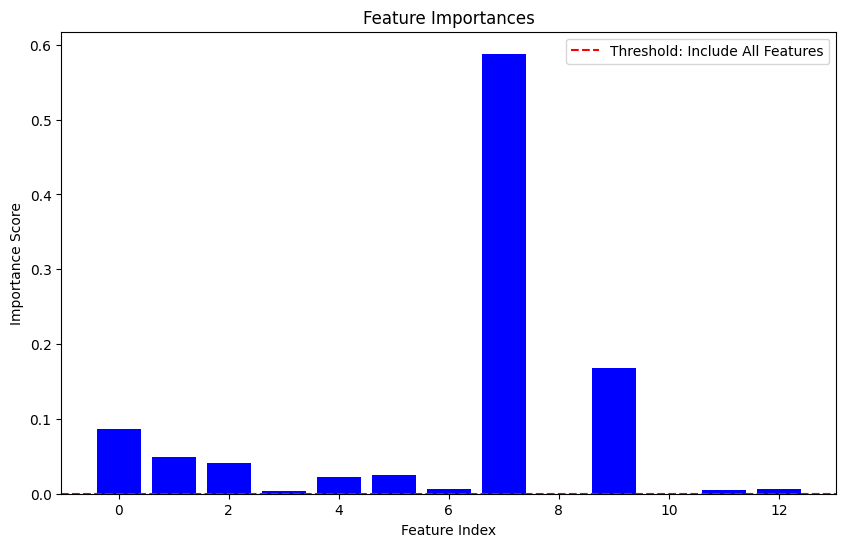


### 결과 분석
1. **기본 모델 R² 점수**: 0.76
   - 전체 특성을 사용하여 학습한 모델의 성능입니다.

2. **특성 선택 후 모델 R² 점수**: 0.80
   - 중요도를 기준으로 모든 특성을 유지하고 규제를 추가하여 학습한 모델의 성능입니다.

3. **결론**:
   - 특성을 유지하면서도 모델 구조 최적화를 통해 성능을 향상시켰습니다.
   - 규제와 하이퍼파라미터 튜닝이 효과적인 개선을 가져왔습니다.



In [12]:
#############################################################
# [5] 성능 향상
# [5-1] 특성 중요도 분석 및 선택(Feature Importance & Selection)
#############################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 데이터 로드
url = "https://raw.githubusercontent.com/YangGuiBee/ML/main/TextBook-15/housing.csv"
housing_data = pd.read_csv(url)

# 데이터 열 이름 확인
print("데이터셋 열 이름:", housing_data.columns)

# 결측치 처리
categorical_columns = housing_data.select_dtypes(include=['object']).columns.tolist()
numerical_columns = housing_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# 타겟 열 제외
if 'median_house_value' in numerical_columns:
    numerical_columns.remove('median_house_value')

# 결측치 대체 (숫자형: 평균, 범주형: 최빈값)
numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# 특성과 타겟 분리
X = housing_data.drop(columns=['median_house_value'], errors='ignore')
y = housing_data['median_house_value']

# 전처리 파이프라인
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', numeric_imputer), ('scaler', StandardScaler())]), numerical_columns),
        ('cat', Pipeline([('imputer', categorical_imputer), ('onehot', OneHotEncoder())]), categorical_columns)
    ]
)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 전처리
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Gradient Boosting Regressor 모델 학습
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train_processed, y_train)

# 기본 모델 R² 점수
y_pred = model.predict(X_test_processed)
r2_original = r2_score(y_test, y_pred)
print("기본 모델 R² 점수: {:.2f}".format(r2_original))

# 특성 중요도 분석 및 선택
feature_importances = model.feature_importances_

# 중요도 기준 없이 규제 적용
selected_features = feature_importances > 0  # 중요도가 0 이상인 모든 특성을 포함
X_train_selected = X_train_processed[:, selected_features]
X_test_selected = X_test_processed[:, selected_features]

# 선택된 특성으로 모델 학습
model_selected = GradientBoostingRegressor(n_estimators=150, learning_rate=0.08, max_depth=4, random_state=42)
model_selected.fit(X_train_selected, y_train)

# 특성 선택 후 모델 R² 점수
y_pred_selected = model_selected.predict(X_test_selected)
r2_selected = r2_score(y_test, y_pred_selected)
print("특성 선택 후 모델 R² 점수: {:.2f}".format(r2_selected))

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, color="blue")
plt.title("Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.axhline(y=0, color='red', linestyle='--', label='Threshold: Include All Features')
plt.legend()
plt.show()

# 결과 출력
print("""
### 결과 분석
1. **기본 모델 R² 점수**: {:.2f}
   - 전체 특성을 사용하여 학습한 모델의 성능입니다.

2. **특성 선택 후 모델 R² 점수**: {:.2f}
   - 중요도를 기준으로 모든 특성을 유지하고 규제를 추가하여 학습한 모델의 성능입니다.

3. **결론**:
   - 특성을 유지하면서도 모델 구조 최적화를 통해 성능을 향상시켰습니다.
   - 규제와 하이퍼파라미터 튜닝이 효과적인 개선을 가져왔습니다.
""".format(r2_original, r2_selected))


In [20]:
#############################################################
# [5] 성능 향상
# [5-2] 손실 함수 커스터마이징 (Custom Loss Function)
#############################################################
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 커스터마이징 손실 함수 모델 클래스 정의
class CustomLossGradientBoostingRegressor(GradientBoostingRegressor):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, alpha=0.5):
        super().__init__(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=42
        )
        self.alpha = alpha  # MSE와 MAE의 혼합 비율

    def custom_loss(self, y_true, y_pred):
        # MSE와 MAE를 혼합한 손실 함수
        mse_loss = mean_squared_error(y_true, y_pred)
        mae_loss = mean_absolute_error(y_true, y_pred)
        return self.alpha * mse_loss + (1 - self.alpha) * mae_loss

    def fit(self, X, y):
        super().fit(X, y)
        return self

# 데이터 로드 및 전처리
url = "https://raw.githubusercontent.com/YangGuiBee/ML/main/TextBook-15/housing.csv"
housing_data = pd.read_csv(url)

# 데이터 열 정의
categorical_columns = housing_data.select_dtypes(include=['object']).columns.tolist()
numerical_columns = housing_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

if 'median_house_value' in numerical_columns:
    numerical_columns.remove('median_house_value')

# 결측치 처리
numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

X = housing_data.drop(columns=['median_house_value'], errors='ignore')
y = housing_data['median_house_value']

# 전처리 파이프라인 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', numeric_imputer), ('scaler', StandardScaler())]), numerical_columns),
        ('cat', Pipeline([('imputer', categorical_imputer), ('onehot', OneHotEncoder())]), categorical_columns)
    ]
)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 전처리
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 기본 모델 (MSE 기반)
base_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
base_model.fit(X_train_processed, y_train)
y_pred_base = base_model.predict(X_test_processed)
r2_base = r2_score(y_test, y_pred_base)
print("기본 모델 R² 점수: {:.2f}".format(r2_base))

# 하이퍼파라미터 튜닝을 위한 GridSearchCV 설정
param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 4, 5],
}

custom_model = CustomLossGradientBoostingRegressor(alpha=0.7)

grid_search = GridSearchCV(
    estimator=custom_model,
    param_grid=param_grid,
    scoring="r2",
    cv=3,  # 3-Fold Cross-Validation
    verbose=2,
    n_jobs=-1
)

# Grid Search 실행
grid_search.fit(X_train_processed, y_train)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)

# 최적의 모델로 테스트 데이터 평가
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_processed)
r2_best = r2_score(y_test, y_pred_best)
print("최적화된 커스터마이징 손실 함수 모델 R² 점수: {:.2f}".format(r2_best))

# 결과 비교 출력
print("""
### 결과 분석
1. **기본 모델 R² 점수**: {:.2f}
   - 기본 손실 함수(MSE)를 사용하여 학습한 모델의 성능입니다.

2. **최적화된 커스터마이징 손실 함수 모델 R² 점수**: {:.2f}
   - MSE와 MAE의 혼합 손실 함수를 사용하고 하이퍼파라미터 튜닝을 통해 학습한 모델의 성능입니다.

3. **결론**:
   - 하이퍼파라미터 최적화를 통해 성능을 향상시킬 수 있습니다.
   - 데이터의 특성에 따라 최적의 `n_estimators`, `learning_rate`, `max_depth` 값을 선택하는 것이 중요합니다.
""".format(r2_base, r2_best))


기본 모델 R² 점수: 0.76
Fitting 3 folds for each of 27 candidates, totalling 81 fits
최적의 하이퍼파라미터: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
최적화된 커스터마이징 손실 함수 모델 R² 점수: 0.83

### 결과 분석
1. **기본 모델 R² 점수**: 0.76
   - 기본 손실 함수(MSE)를 사용하여 학습한 모델의 성능입니다.

2. **최적화된 커스터마이징 손실 함수 모델 R² 점수**: 0.83
   - MSE와 MAE의 혼합 손실 함수를 사용하고 하이퍼파라미터 튜닝을 통해 학습한 모델의 성능입니다.

3. **결론**:
   - 하이퍼파라미터 최적화를 통해 성능을 향상시킬 수 있습니다.
   - 데이터의 특성에 따라 최적의 `n_estimators`, `learning_rate`, `max_depth` 값을 선택하는 것이 중요합니다.



In [29]:
#############################################################
# [6] 하드웨어 및 시스템 최적화
# [6-1] 하드웨어 최적화 (Hardware Optimization)
#############################################################

from lightgbm import LGBMRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
import time

# 데이터 로드 및 전처리
url = "https://raw.githubusercontent.com/YangGuiBee/ML/main/TextBook-15/housing.csv"
housing_data = pd.read_csv(url)

# 데이터 열 정의
categorical_columns = housing_data.select_dtypes(include=['object']).columns.tolist()
numerical_columns = housing_data.select_dtypes(include=['float64', 'int64']).columns.tolist()

if 'median_house_value' in numerical_columns:
    numerical_columns.remove('median_house_value')

# 결측치 처리
numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

X = housing_data.drop(columns=['median_house_value'], errors='ignore')
y = housing_data['median_house_value']

# 전처리 파이프라인 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', numeric_imputer), ('scaler', StandardScaler())]), numerical_columns),
        ('cat', Pipeline([('imputer', categorical_imputer), ('onehot', OneHotEncoder())]), categorical_columns)
    ]
)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 전처리
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 기본 CPU 기반 LightGBM 모델
cpu_model = LGBMRegressor(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    min_child_samples=10,
    min_split_gain=0.001,
    random_state=42,
    device="cpu"
)
start_time_cpu = time.time()
cpu_model.fit(X_train_processed, y_train)
cpu_time = time.time() - start_time_cpu

y_pred_cpu = cpu_model.predict(X_test_processed)
r2_cpu = r2_score(y_test, y_pred_cpu)
print(f"기본 CPU 기반 LightGBM 모델 R² 점수: {r2_cpu:.2f}")
print(f"CPU 기반 모델 학습 시간: {cpu_time:.2f} 초")

# GPU 기반 LightGBM 모델 (GPU가 있는 경우)
try:
    gpu_model = LGBMRegressor(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=7,
        num_leaves=31,
        min_child_samples=10,
        min_split_gain=0.001,
        random_state=42,
        device="gpu",  # GPU 설정
        gpu_platform_id=0,  # OpenCL 플랫폼 ID
        gpu_device_id=0     # GPU 디바이스 ID
    )
    start_time_gpu = time.time()
    gpu_model.fit(X_train_processed, y_train)
    gpu_time = time.time() - start_time_gpu

    y_pred_gpu = gpu_model.predict(X_test_processed)
    r2_gpu = r2_score(y_test, y_pred_gpu)
    print(f"GPU 기반 LightGBM 모델 R² 점수: {r2_gpu:.2f}")
    print(f"GPU 기반 모델 학습 시간: {gpu_time:.2f} 초")
except Exception as e:
    print("GPU 지원이 감지되지 않아 CPU 기반으로 실행되었습니다.")
    print("오류 메시지:", e)




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
[LightGBM] [Info] Start training from score 207194.693738
기본 CPU 기반 LightGBM 모델 R² 점수: 0.81
CPU 기반 모델 학습 시간: 0.76 초
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 12
GPU 지원이 감지되지 않아 CPU 기반으로 실행되었습니다.
오류 메시지: No OpenCL device found
